# Assessing significance of neutral objectives in League of Legends

### Table of contents

1. [Loading and saving libraries/data](#load)

2. [Querying Riot's API](#query)

3. [Explore data](#explore)

4. [Machine learning](#machine)

League of legends is a 5v5 multiplayer strategy game where the winning team must destroy enemy structures. Outside of the direct winning objectives, there are neutral objectives that either team can capture in order to gain temporary or permanent buffs: dragons, rift heralds, and baron nashors. 

The relative benefits and importance of these neutral monster objectives are widely debated. The objectives are geographically split on the game map, with rift herald and baron spawning on the top side and dragons spawning on the bottom side of the map. The split locations often force teams to choose between prioritizing the two locations; the enemy team is usually able to "trade" these objectives by taking the other objective even if they are unable to contest the same objective. The objective dilemma  becomes more significant in professional e-sports, where skilled players are able to utilize small advantages, such as buffs from capturing neutral objectives, to snowball games to victories.

This project aims to provide insight on the relative importance of neutral objectives throughout the course of the game, helping players make optimal decisions regarding objectives. Although there are some predictive models for league, such as based on champion selection and professional players, I have not found one focused on the importance of objectives nor one that is up-to-date with the latest objective changes for the current season.

The anaylzed match data was extracted via the [Riot Games API](https://developer.riotgames.com/apis) and contains over 20,000 NA high elo solo/duo ranked matches from masters, Grandmasters, and Challenger tier players in the North American server.

There are two parts to this project:
1. Make a basic classifier model for predicting the winner of a game at different times of a game
    - the endpoint team stats will be used to predict the winner for each game. These stats include game duration and the difference in number of objectives taken by each team. Other commonly included parameters such as team gold and kills because of the project's focus on objectives.
    - precision and f1-score will be used to evaluate the effectiveness of the trained model
2. Assess the relative importance of neutral objectives to predicting game outcomes
    - The number of objectives captured up to different timepoints in a game will be used to predict the winner. This will examine the importance of different objective types in predicting the game winner.
    - feature importance weights will be extracted from the trained model

<a id='load'></a>
### Loading libraries and data, saving data

In [2]:
import requests, json
import numpy as np
import importlib
import pandas as pd
import pickle
import os

from riotwatcher import LolWatcher, ApiError
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import pdb
import warnings
warnings.filterwarnings('ignore')

In [5]:
from src import data_preprocessing as p
from src import visuals as v

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, classification_report

In [8]:
%%time
gamestate_by_time_dict = p.load_pkl('data/gamestate_by_time_dict.pkl')

Wall time: 52.9 ms


In [9]:
%%time
match_results_dict = p.load_pkl('data/match_results_dict.pkl')

Wall time: 47.9 ms


In [4]:
%%time
match_detail_dict = p.load_pkl('data/match_detail_dict.pkl')

Wall time: 4.01 s


In [5]:
%%time
match_timeline_dict = p.load_pkl('data/match_timeline_dict.pkl')

Wall time: 4min 17s


In [6]:
%%time
matchlist = p.load_pkl('data/matchlist.pkl')

Wall time: 23 ms


In [23]:
int(match_detail_dict[3447355549]['gameDuration']/60)

32

In [8]:
len(match_timeline_dict[3447355549]['frames'])

34

In [32]:
match_timeline_dict[3447355549]['frames']

[{'participantFrames': {'1': {'participantId': 5,
    'position': {'x': 560, 'y': 581},
    'currentGold': 500,
    'totalGold': 500,
    'level': 1,
    'xp': 0,
    'minionsKilled': 0,
    'jungleMinionsKilled': 0,
    'dominionScore': 0,
    'teamScore': 0},
   '2': {'participantId': 1,
    'position': {'x': 560, 'y': 361},
    'currentGold': 500,
    'totalGold': 500,
    'level': 1,
    'xp': 0,
    'minionsKilled': 0,
    'jungleMinionsKilled': 0,
    'dominionScore': 0,
    'teamScore': 0},
   '3': {'participantId': 3,
    'position': {'x': 351, 'y': 293},
    'currentGold': 500,
    'totalGold': 500,
    'level': 1,
    'xp': 0,
    'minionsKilled': 0,
    'jungleMinionsKilled': 0,
    'dominionScore': 0,
    'teamScore': 0},
   '4': {'participantId': 4,
    'position': {'x': 221, 'y': 471},
    'currentGold': 500,
    'totalGold': 500,
    'level': 1,
    'xp': 0,
    'minionsKilled': 0,
    'jungleMinionsKilled': 0,
    'dominionScore': 0,
    'teamScore': 0},
   '5': {'parti

In [3]:
#text_file = open("high_elo_accIds.txt", "w")
#text_file.write()
#text_file.close()

In [613]:
p.save_txt(str(match_stats_dict), 'data/match_stats_dict.txt')

In [ ]:
p.pkl_file(match_dict, 'data/match_dict.pkl')

In [585]:
p.pkl_file(high_elo_accIds, 'data/high_elo_accIds.pkl')

In [678]:
p.pkl_file(match_detail_dict, 'data/match_detail_dict.pkl')

In [679]:
p.pkl_file(match_stats_dict, 'data/match_stats_dict.pkl')

In [910]:
p.pkl_file(match_timeline_dict, 'data/match_timeline_dict.pkl')

In [10]:
p.pkl_file(matchlist, 'data/matchlist.pkl')

In [121]:
p.pkl_file(list_time_dicts, 'data/list_time_dicts.pkl')

In [229]:
p.pkl_file(match_results_dict, 'data/match_results_dict.pkl')

In [230]:
p.pkl_file(gamestate_by_time_dict, 'data/gamestate_by_time_dict.pkl')

In [92]:
p.pkl_file(filled_gamestate_by_time_dict, 'data/filled_gamestate_by_time_dict.pkl')

In [71]:
p.pkl_file(best_clf, 'data/best_clf.pkl')

In [6]:
len(match_detail_dict)

20275

In [7]:
len(match_timeline_dict)

28627

In [908]:
df.to_csv('data/match_stats_df.csv')

In [14]:
df_results.to_csv('data/df_results.csv')

In [31]:
df_filled.to_csv('data/df_filled_results.csv')

In [82]:
df = pd.read_csv('data/match_stats_df.csv')

In [208]:
def rand(to_shuffle):
    '''
    Shuffle a copy without disturbing original list
    '''
    shuffled_copy = to_shuffle.copy()
    random.shuffle(shuffled_copy)
    return shuffled_copy

<a id='query'></a>
# Extracting data from Riot API: 

Riot API only allows for extraction of match IDs through user accounts, not through elo rankings and times. A list of high elo matches were obtained by extracting summoner names of high elo ranks and compiling a list of their most recent matches. The riotwatcher wrapper API was used to facilitate extracting data.

## Summoner names

Get a list of players in high elo ranks (Master, Grandmaster, Challenger)

In [593]:
# golbal variables
api_key = 'RGAPI-14651911-2597-416c-9c96-63fa72f1a5bb'
watcher = LolWatcher(api_key)
my_region = 'na1'
queue_type = 'RANKED_SOLO_5x5'

In [27]:
#get list of high elo players
chall_players = watcher.league.challenger_by_queue(my_region, queue_type)
master_players = watcher.league.masters_by_queue(my_region, queue_type)
GM_players = watcher.league.grandmaster_by_queue(my_region, queue_type)

In [50]:
#compile list of summoner IDs for list of high elo players
high_elo_summonerIds = []
for entry in chall_players['entries']:
    high_elo_summonerIds.append(entry['summonerId'])
for entry in master_players['entries']:
    high_elo_summonerIds.append(entry['summonerId'])
for entry in GM_players['entries']:
    high_elo_summonerIds.append(entry['summonerId'])

In [47]:
chall_players

{'tier': 'CHALLENGER',
 'leagueId': 'c60807e8-6afb-38fd-ab9b-ae8588dc8b27',
 'queue': 'RANKED_SOLO_5x5',
 'name': "Kha'Zix's Warriors",
 'entries': [{'summonerId': 'aKgW_wqkTJ-nkuMnAzmcNjdlsWCFRlACgLFdttNBWvKcZIc',
   'summonerName': 'Kandori',
   'leaguePoints': 841,
   'rank': 'I',
   'wins': 224,
   'losses': 187,
   'veteran': True,
   'inactive': False,
   'freshBlood': False,
   'hotStreak': False},
  {'summonerId': 'bE44fVre61r8szwuoOjlDx3_29SkNDH9qslIPoIX6MdNQXyN',
   'summonerName': 'ADCADC123',
   'leaguePoints': 1160,
   'rank': 'I',
   'wins': 344,
   'losses': 277,
   'veteran': True,
   'inactive': False,
   'freshBlood': False,
   'hotStreak': False},
  {'summonerId': 'KouvFsnpxQ9H91W09mioR_0-qS0wduVKPLpjnIZUWdLuT3to',
   'summonerName': 'Kral Closer',
   'leaguePoints': 979,
   'rank': 'I',
   'wins': 313,
   'losses': 268,
   'veteran': True,
   'inactive': False,
   'freshBlood': False,
   'hotStreak': True},
  {'summonerId': 'QhGwGPOLg2fT2wdonRDW-LdFok_2Ebr-zeYOHO42w

In [46]:
chall_players['entries'][0]

{'summonerId': 'aKgW_wqkTJ-nkuMnAzmcNjdlsWCFRlACgLFdttNBWvKcZIc',
 'summonerName': 'Kandori',
 'leaguePoints': 841,
 'rank': 'I',
 'wins': 224,
 'losses': 187,
 'veteran': True,
 'inactive': False,
 'freshBlood': False,
 'hotStreak': False}

## Account ID

Convert summoner ID's to account ID's (to use for obtaining match IDs later)

In [55]:
watcher.summoner.by_id(my_region, 'aKgW_wqkTJ-nkuMnAzmcNjdlsWCFRlACgLFdttNBWvKcZIc')['accountId']

'_JBrw5ZEaW9y9ABf2VQ9Zwul4lJmTngiuVsm7XznoKHxOw'

In [65]:
test_accId = '_JBrw5ZEaW9y9ABf2VQ9Zwul4lJmTngiuVsm7XznoKHxOw'

In [56]:
%%time
#convert summoner IDs into account IDs to obtain match IDs later
high_elo_accIds = []
for summonerID in high_elo_summonerIds:
    high_elo_accIds.append(watcher.summoner.by_id(my_region, summonerID)['accountId'])

In [57]:
len(high_elo_accIds)

1255

In [58]:
high_elo_accIds

['_JBrw5ZEaW9y9ABf2VQ9Zwul4lJmTngiuVsm7XznoKHxOw',
 'hp3wQzf0Qcs5Fnj45_P0AUXBz7-DAYnJUYWKrcbSwCh8urCBpHG-GrrS',
 '29IxleXM4jPS5T2KmsFdxcbZFZlCCzD4-OQxXI4gURHVse8nyP_OYfYc',
 'DDzNcXIIaSnXqjFJWjvaOtOqRQoXiohNDAAF9Vv7tU0Gt1k',
 'DmIsL2U_YfkFvgPHAaNc7gnnei2xALo0CxikkoQ0SGjYhMU',
 'vKZQmQbwbaA2KWAhnK_pX8CI-G54swj6jHPvB32iIk03aA',
 'p-FDVXL2PVCuWf4-NyWOwfJsUsTwkmTsdvexpCUwRr0Rqf2J1Siq9IQx',
 'XYHw7RBsdt4zKlz6vBy6Azhst8yjFubcHSfLcfgt21_m0Q',
 '49ktgxVhbcxyTXpK-5F4lhsCRzEyLocg7aVKeqy9_Q',
 'GDjOrucdAH-Eydcm7Rdjmht69RbnVJ-dCLP9gstfMuqndj4',
 'Wfr7qym3OXhzMhjBxqNzo3N-L0HfHhW0_j4ywWuW7L0XbA',
 'mq9jRuXgZNXVxDKDMc92HPMZPSmHFF5dNdAbZAMIjntINzk',
 'GjCSfQ1jcIzOrQ49U8n9oUQaQRBPXpl2Jaj232tQq24xMJAQedSNnoRB',
 'NGYs92mmMn4U0WnZeYx8X10DlamLMOAKlbLOvLHXVx9YtwE',
 '3-TmucbFNpODk8hOqAX50o8gVvzUlgFWcHlAy9o2X7L6g70',
 '1eYnztK2x432-JeNev1eiDIMqLKWFtlE21IINb6pG2XWQs0Z1hq24gjW',
 'xOlB6nXvNMjW-h81jpuU0bkzwadmidIydQLUcppsRI0RJVA',
 'vOOeJ_pye8EbVBPcKOeP9LXDIZQ92z6cb6Sxza_k1rR5mw',
 'BK3NHYNRh0EXUz7SgaucgbDn79d

In [62]:
#since the summoners extracted by rank, randomize list to reduce chance of bias
import random
unordered_accIds = high_elo_accIds.copy()
random.shuffle(unordered_accIds)

In [63]:
unordered_accIds

['RnUXqlcP4OlBPCbrSKoAxsHtDmaNafqfAEd6_WDTcMQ-6gTrD-xjfS-6',
 'jyGwEUPhn4LIoL-MDW15jpug3c3vTEi-TF-6JZaLIo3Uh7RgpGMA6zOQ',
 'oyZh8APFpeMuaSNjzHo9GOkIhlHnilk2jwM0AzzWlcdmAg',
 '_Xp0EnkmOv20Sb5D8cdCWiesDpw14i5tnQbTDGc3dcsROg',
 'hJn4wTkJszvRVi-j1m52OhydZ6JZ93D0puqqN111XW52tiMBq20N7bXo',
 '7EFoYbzJJVBzk2CPC_fdkTQ5xS_LLGYoxRC5QCwpljF9hzk',
 'L6p1svYEiPHFZ1cHeUZnNEwApCpcGk9v-hOE0YltcShOo1hP85eJdVyf',
 'm5CgWtjAl6qHwB0-52nmGAWPzkG7khFlCpVOEqqAFeSGkQ',
 '7kGR7NMehaF3WzQooW_WfYPYuNDRW8ktMAKah64-e3caJoQ',
 'Q8r5ILpE4ncPzl6xVgzoZ6_4SAKKN3M5Pwnu-292Bf-2JWc',
 '6SC1rPBNQ-jHCzyjwLA3YmfPN11JfrPEiGzVJ6foXNg',
 'HmKihDpDOtwTEWbuv7VoaumVpk8i8JEFE9BRw9pNgChKiyc',
 'wLBt3Av_w0TfRz5sUkDlt7XyAz8iYb9NmUx2jV_kLhp2hbM',
 'Pu-MvEKxoqIRUpP_cCgggBr9U_SGgndDSDHdyOSqGqwWt9M',
 'ClK13mMxV6HODIQTi2wWO65j9ajuWafKOMV7vd1WRq5LQw',
 'JPTlNSPJI09TI7W5OfMTkcjYk2Il-7esHNlg_pM_lIjQ2A',
 '_bg48Jwj7oKJ1sEd4z32wxvLOUx1HxV2mCNWASKBcwxFmw',
 'CUNU6EgKyFVAgrykbwJFLihI4NoJzuatvB_eCJyeRALkiuM',
 '_sPMOEJQ8lyc8vXpTdP7s_JqhXhOgeyioGzi

In [155]:
#create a randomized list to reduce  any chance of bias
import random
unordered_accIds = high_elo_accIds.copy()
random.shuffle(unordered_accIds)

## Matchs
Compile list of most recent 100 matches for each account ID, then compile the match IDs into a single list of account IDs with no duplicates.

In [160]:
%%time
#for all players in high elo, find the match IDs of their most recent games and compile to a set. 
#match_dict = {} #initialize new dictionary

#for each account ID, find a list of their ??10??20?? of their most recent matches 
#and save it to a new dictionary

for acc_ID in unordered_accIds:
    if acc_ID not in match_dict.keys():
        my_matches = watcher.match.matchlist_by_account(my_region, acc_ID)['matches']
        my_matches_list = list(x['gameId'] for x in my_matches)
        #my_matches_list = []
        #for i in range(len(my_matches)):
            #my_matches_list.append(my_matches[i]['gameId'])
        match_dict[acc_ID] = my_matches_list

Wall time: 10min 23s


In [171]:
matchlist = set()
for acc_ID in match_dict:
    matchlist.update(match_dict[acc_ID])

In [172]:
len(matchlist)

67519

In [190]:
matchlist = list(matchlist)

In [ ]:
my_matches = watcher.match.matchlist_by_account(my_region, me['accountId'])

In [69]:
my_matches = watcher.match.matchlist_by_account(my_region, test_accId)['matches']
my_matches

[{'platformId': 'NA1',
  'gameId': 3447355549,
  'champion': 115,
  'queue': 400,
  'season': 13,
  'timestamp': 1591160342189,
  'role': 'DUO_CARRY',
  'lane': 'BOTTOM'},
 {'platformId': 'NA1',
  'gameId': 3447347793,
  'champion': 412,
  'queue': 450,
  'season': 13,
  'timestamp': 1591158041136,
  'role': 'SOLO',
  'lane': 'BOTTOM'},
 {'platformId': 'NA1',
  'gameId': 3447015320,
  'champion': 246,
  'queue': 420,
  'season': 13,
  'timestamp': 1591143391496,
  'role': 'DUO_SUPPORT',
  'lane': 'NONE'},
 {'platformId': 'NA1',
  'gameId': 3446937263,
  'champion': 246,
  'queue': 420,
  'season': 13,
  'timestamp': 1591139877306,
  'role': 'SOLO',
  'lane': 'MID'},
 {'platformId': 'NA1',
  'gameId': 3446970246,
  'champion': 246,
  'queue': 420,
  'season': 13,
  'timestamp': 1591137387186,
  'role': 'SOLO',
  'lane': 'MID'},
 {'platformId': 'NA1',
  'gameId': 3446912575,
  'champion': 55,
  'queue': 420,
  'season': 13,
  'timestamp': 1591133624486,
  'role': 'SOLO',
  'lane': 'MID'}

In [70]:
my_matches_list = list(x['gameId'] for x in my_matches)

In [71]:
my_matches_list

[3447355549,
 3447347793,
 3447015320,
 3446937263,
 3446970246,
 3446912575,
 3446855076,
 3446564676,
 3446433775,
 3446382969,
 3446265550,
 3446242002,
 3446226114,
 3444752826,
 3444672632,
 3443958873,
 3443901158,
 3443799401,
 3443831158,
 3443368198,
 3443340240,
 3443139498,
 3442877316,
 3441767271,
 3441813815,
 3441772095,
 3441718344,
 3438295929,
 3438264800,
 3438198574,
 3438204757,
 3438072464,
 3437956759,
 3437904969,
 3437941842,
 3437548546,
 3437531203,
 3436969894,
 3436496383,
 3436362101,
 3436323645,
 3436191324,
 3435645707,
 3435652738,
 3435621194,
 3435548984,
 3435575298,
 3434993779,
 3434216162,
 3434205234,
 3434204056,
 3434222158,
 3434210648,
 3434156847,
 3434161784,
 3434038466,
 3433898782,
 3433688558,
 3433681845,
 3433347305,
 3433330722,
 3432610494,
 3432421088,
 3430911015,
 3430837933,
 3429983152,
 3429919709,
 3429895051,
 3429351211,
 3429241006,
 3428771055,
 3428668239,
 3428694955,
 3428702571,
 3428679989,
 3428593863,
 3428385614,

In [73]:
test_gameId = 3447355549

## Match details

The match details are obtained from 2 API endpoints:
- match.by_id - gives summary stats of both teams at the end of the game
- match.timeline_by_match - gives detailed information of all players on each team for every minute of the game

In [560]:
match_stats

{'Winner': 'red',
 'blueElemDragNum': 4,
 'blueFIRE_DRAGON': 1,
 'redElemDragNum': 0,
 'redFIRE_DRAGON': 0,
 'drag1type': 'FIRE_DRAGON',
 'drag1team': 'blue',
 'drag1time': 372155,
 'blueWATER_DRAGON': 1,
 'redWATER_DRAGON': 0,
 'drag2type': 'WATER_DRAGON',
 'drag2team': 'blue',
 'drag2time': 694819,
 'RIFTHERALD1team': 'red',
 'RIFTHERALD1time': 899295,
 'blueAIR_DRAGON': 2,
 'redAIR_DRAGON': 0,
 'drag3type': 'AIR_DRAGON',
 'drag3team': 'blue',
 'drag3time': 1012964,
 'SoulType': 'AIR_DRAGON',
 'SoulTeam': 'blue',
 'drag4type': 'AIR_DRAGON',
 'drag4team': 'blue',
 'drag4time': 1353936,
 'drag5type': 'ELDER_DRAGON',
 'drag5team': 'blue',
 'drag5time': 1824420,
 'firstTower': 'red',
 'firstInhibitor': 'red',
 'firstDragon': 'red',
 'firstRiftHerald': 'blue',
 'bluebaronKills': 0,
 'redbaronKills': 0,
 'blueriftHeraldKills': 1,
 'redriftHeraldKills': 0}

In [75]:
match_detail = watcher.match.by_id(my_region, test_gameId)
match_detail

{'gameId': 3447355549,
 'platformId': 'NA1',
 'gameCreation': 1591160342189,
 'gameDuration': 1968,
 'queueId': 400,
 'mapId': 11,
 'seasonId': 13,
 'gameVersion': '10.11.322.2991',
 'gameMode': 'CLASSIC',
 'gameType': 'MATCHED_GAME',
 'teams': [{'teamId': 100,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': True,
   'firstDragon': False,
   'firstRiftHerald': True,
   'towerKills': 4,
   'inhibitorKills': 0,
   'baronKills': 1,
   'dragonKills': 1,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 154, 'pickTurn': 1},
    {'championId': 89, 'pickTurn': 2},
    {'championId': 38, 'pickTurn': 3},
    {'championId': 53, 'pickTurn': 4},
    {'championId': 17, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': False,
   'firstDragon': True,
   'firstRiftHerald': False,
   'towerKills'

In [182]:
#match_detail_dict = {} #initialize match detail dict

HTTPError: 503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3430810044

In [677]:
len(match_detail_dict)

20275

In [587]:
%%time
#retrieve match details
@retry(stop_max_attempt_number=20, wait_random_min=1000, wait_random_max=2000)
def retrieve_match_detail():
    for gameId in matchlist:
        if gameId not in match_detail_dict.keys():
            match_detail = watcher.match.by_id(my_region, gameId)
            match_detail_dict[gameId] = match_detail

Wall time: 0 ns


In [676]:
%%time
retrieve_match_detail()

From cffi callback <function _verify_callback at 0x000001C0EEDBCF78>:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 311, in wrapper
    @wraps(callback)
KeyboardInterrupt


KeyboardInterrupt: 

In [279]:
# match_timeline_dict = {}  #initialize match timeline dict

### Match Timeline

In [625]:
%%time
len(match_timeline_dict)

Wall time: 1.05 ms


28627

In [287]:
from retrying import retry

In [588]:
@retry(stop_max_attempt_number=20, wait_random_min=1000, wait_random_max=2000)
def retrieve_match_timeline():
    #retrieve match timeline:
    for gameId in matchlist:
        if gameId not in match_timeline_dict.keys():
            match_timeline = watcher.match.timeline_by_match(my_region, gameId)
            match_timeline_dict[gameId] = match_timeline

In [624]:
%%time
retrieve_match_timeline()

HTTPError: 504 Server Error: Gateway Timeout for url: https://na1.api.riotgames.com/lol/match/v4/timelines/by-match/3434010758

In [96]:
match_timeline

{'frames': [{'participantFrames': {'1': {'participantId': 5,
     'position': {'x': 560, 'y': 581},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '2': {'participantId': 1,
     'position': {'x': 560, 'y': 361},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '3': {'participantId': 3,
     'position': {'x': 351, 'y': 293},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'dominionScore': 0,
     'teamScore': 0},
    '4': {'participantId': 4,
     'position': {'x': 221, 'y': 471},
     'currentGold': 500,
     'totalGold': 500,
     'level': 1,
     'xp': 0,
     'minionsKilled': 0,
     'jungleMinionsKilled': 0,
     'domini

In [547]:
match_obj_dict = {} #iinitialize dict

# Data Preprocessing

### Extract match info / Create features
Exttract relevant match information from the match_details and match_timeline endpoints

In [49]:
bool_params = ['firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald']
num_params = ['baronKills', 'riftHeraldKills', 'dragonKills']

In [86]:
#obtain the longest game time in the dataset to determine 
#a reasonable maximum time interval for obtaining gamestate
df['GameDuration'].max()/60

58.45

In [178]:
%%time
match_results_dict, list_time_dicts = gamestate_by_time(list(match_detail_dict.keys()))

Wall time: 10min 28s


In [170]:
match_results_dict

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': 1,
  'dragonKillsdiff': -2},
 3435528193: {'GameDuration': 1516,
  'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': 0,
  'dragonKillsdiff': 0},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstBaron': 'blue',
  'firstDragon': 'red',
  'baronKillsdiff': 1,
  'riftHeraldKillsdiff': 0,
  'dragonKillsdiff': -3},
 3426877449: {'GameDuration': 915,
  'Winner': 'red',
  'firstTower': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'red',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': -1,
  'dragonKillsdiff': -2},
 3419144205: {'GameDuration': 1176,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHer

In [113]:
match_results_dict

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'firstTower': 'red',
  'firstInhibitor': 'red',
  'firstDragon': 'red',
  'firstRiftHerald': 'blue',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': 1,
  'dragonKillsdiff': -2},
 3435528193: {'GameDuration': 1516,
  'Winner': 'blue',
  'firstTower': 'blue',
  'firstInhibitor': 'red',
  'baronKillsdiff': 0,
  'riftHeraldKillsdiff': 0,
  'dragonKillsdiff': 0}}

In [127]:
len(match_results_dict)

20275

In [126]:
len(list_time_dicts[35])

1474

#### Convert to dataframes

In [141]:
list_time_dicts.keys()

dict_keys([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])

In [189]:
#investigate the number of games at each available time interval and whether the games have objective events
for time in list_time_dicts.keys():
    print(('\n {} min: {} games, {} games with events').format(time, 
                                                    len(list_time_dicts[time]), 
                                                    p.count_dictvals_above_thres(list_time_dicts[time].values())) )
#len(list_time_dicts[5])


 5 min: 20156 games, 0 games with events

 10 min: 20012 games, 20012 games with events

 15 min: 18641 games, 18641 games with events

 20 min: 14060 games, 14060 games with events

 25 min: 8722 games, 8722 games with events

 30 min: 4342 games, 4342 games with events

 35 min: 1474 games, 1474 games with events

 40 min: 370 games, 370 games with events

 45 min: 68 games, 68 games with events

 50 min: 10 games, 10 games with events

 55 min: 2 games, 2 games with events


In [239]:
#summarize in df
tot_games = df_post.shape[0] #total num of games
num_games_by_time_df = pd.DataFrame(index=[str(str(x)+' min') for x in list_time_dicts.keys()], columns=['Games', 'Games with obj events'])
for time in list_time_dicts.keys():
    num_games_by_time_df['Games'][str(str(time)+' min')] = len(list_time_dicts[time])
    num_games_by_time_df['Games with obj events'][str(str(time)+' min')] = count_dictvals_above_thres(list_time_dicts[time].values())
    
    #make column of proportions
    num_games_by_time_df['% Games Remaining'] = num_games_by_time_df['Games']/tot_games*100

In [240]:
num_games_by_time_df

,Games,Games with obj events,% Games Remaining
5 min,20156,0,99.4131
10 min,20012,20012,98.7028
15 min,18641,18641,91.9408
20 min,14060,14060,69.3465
25 min,8722,8722,43.0185
30 min,4342,4342,21.4155
35 min,1474,1474,7.27004
40 min,370,370,1.82491
45 min,68,68,0.335388
50 min,10,10,0.0493218


Since there are only 370 games at the time interval of 40, 35 minutes will be the maximum time interval used for modeling. Minute 5 has also been removed since no neutral objectives are available to take at that time. This is reflected in the 

Note: the length of a game increases as elo decreases, so more time intervals will likely have to be examined if analysis were to expanded to lower elos.

In [136]:
df_times_list = [10, 15, 20, 25, 30, 35]

In [132]:
df_by_time_dict = {}

In [311]:
for time in df_times_list:
    if len(list_time_dicts[time]) > 1000: #arbitary cutoff number of 1000 games was chosen
        gamestate_by_time_dict[time] = pd.DataFrame(list_time_dicts[time]).transpose()

In [312]:
gamestate_by_time_dict[10]

,Winner,AIR_DRAGONdiff,WATER_DRAGONdiff,RIFTHERALDdiff,BARON_NASHORdiff,FIRE_DRAGONdiff,EARTH_DRAGONdiff
3411673088,red,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,blue,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,blue,-1,NaN,NaN,NaN,NaN,NaN
3426877449,red,NaN,-1,-1,0,NaN,NaN
3419144205,red,NaN,NaN,NaN,NaN,-1,NaN
...,...,...,...,...,...,...,...
3444742545,red,NaN,NaN,NaN,NaN,-1,NaN
3424164242,blue,NaN,NaN,NaN,NaN,NaN,1
3405814162,red,NaN,NaN,NaN,NaN,1,NaN
3419838867,blue,NaN,NaN,NaN,NaN,NaN,1


In [12]:
#create df of match_results_dict
#add dragon soul to this df
df_results = pd.DataFrame(match_results_dict).transpose()

In [13]:
df_results

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,baronKillsdiff,riftHeraldKillsdiff,dragonKillsdiff,FIRE_DRAGONdiff,EARTH_DRAGONdiff,firstBaron,FIRE_DRAGONSoul,AIR_DRAGONdiff,ELDER_DRAGONdiff,WATER_DRAGONdiff,EARTH_DRAGONSoul,WATER_DRAGONSoul,AIR_DRAGONSoul
3411673088,1195,red,red,red,red,blue,0,1,-2,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,-3,-2,-1,blue,red,-1,1,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,-1,-2,NaN,-1,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,-2,-1,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444742545,1326,red,red,red,red,red,-1,-1,-3,-1,-1,red,NaN,-1,NaN,NaN,NaN,NaN,NaN
3424164242,1915,blue,blue,blue,blue,blue,1,1,1,NaN,1,blue,NaN,1,NaN,-1,NaN,NaN,NaN
3405814162,1208,red,red,red,blue,blue,0,0,-1,1,-1,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN
3419838867,1305,blue,blue,blue,blue,blue,0,2,3,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


# First look at the data

In [15]:
df_results.columns.values

array(['GameDuration', 'Winner', 'firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'baronKillsdiff',
       'riftHeraldKillsdiff', 'dragonKillsdiff', 'FIRE_DRAGONdiff',
       'EARTH_DRAGONdiff', 'firstBaron', 'FIRE_DRAGONSoul',
       'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff',
       'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul'],
      dtype=object)

In [17]:
var_diff = ['baronKillsdiff','riftHeraldKillsdiff', 
                   'dragonKillsdiff', 'FIRE_DRAGONdiff', 'EARTH_DRAGONdiff', 
                   'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff']
var_team = ['firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'firstBaron', 'FIRE_DRAGONSoul', 
              'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul']
var_firsts = ['firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'firstBaron']
var_dragtypediff = ['FIRE_DRAGONdiff', 'EARTH_DRAGONdiff', 
                   'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff']
var_soul = ['FIRE_DRAGONSoul', 
              'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul']

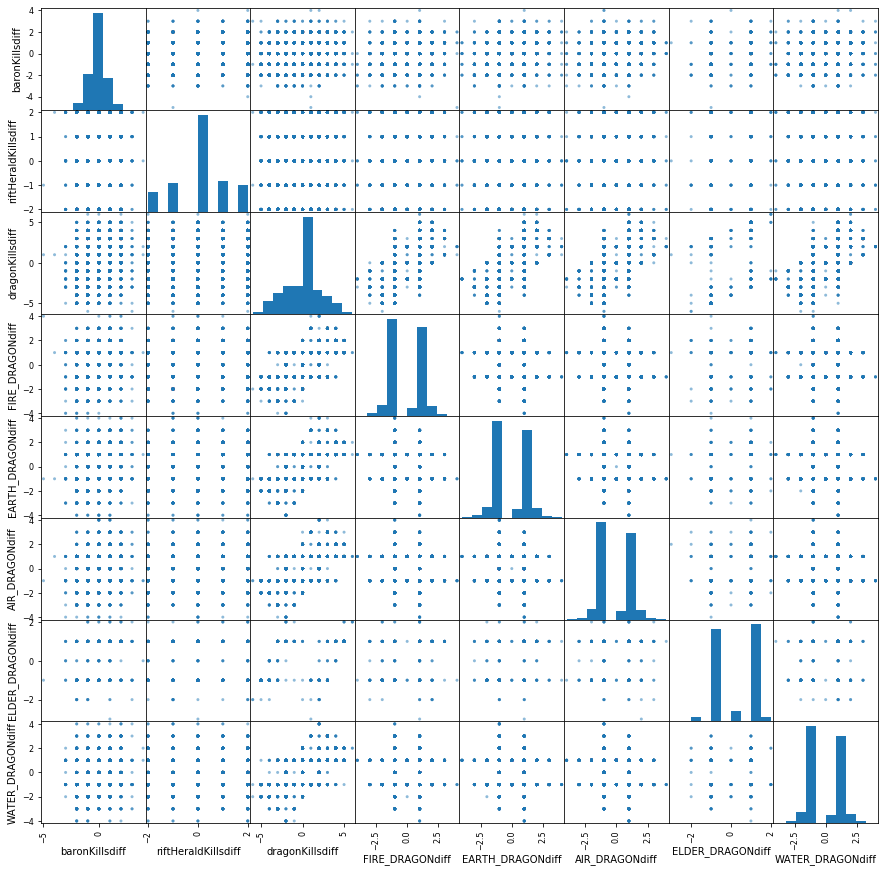

In [18]:
pd.plotting.scatter_matrix(df_post[var_diff].astype(float), figsize = [15, 15]);

Unsurprisingly, there's a lot of multicollinearity between the variables which means that estimators that assume feature independence wouldn't work well.

Text(0, 0.5, '# Games')

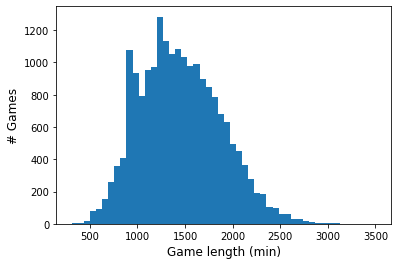

In [715]:
plt.hist(df_dropped['GameDuration'], bins = 50)
plt.xlabel('Game length (min)', fontsize = 12)
plt.ylabel('# Games', fontsize = 12)

### Final cleaning and imputing

There are games where at least one player doesn't connect to the game which results in an early game end - a "remake". Remakes begin at 3 mins and takes a maximum of 90 seconds, hence they'll be removed by removing any games under 5 mins length.

Binary features, with either "blue" or "red" variables, will be encoded to 1 and 0 integers

In [20]:
df_dropped = df_results[df_results['GameDuration'] > 300]

In [21]:
#convert blue and red team to boolean ints
df_clean = df_dropped.replace({'blue': 1, 'red': -1})

In [22]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,baronKillsdiff,riftHeraldKillsdiff,dragonKillsdiff,FIRE_DRAGONdiff,EARTH_DRAGONdiff,firstBaron,FIRE_DRAGONSoul,AIR_DRAGONdiff,ELDER_DRAGONdiff,WATER_DRAGONdiff,EARTH_DRAGONSoul,WATER_DRAGONSoul,AIR_DRAGONSoul
3411673088,1195,-1,-1.0,-1.0,-1.0,1.0,0,1,-2,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,1,1.0,-1.0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,1,-1.0,-1.0,-1.0,NaN,1,0,-3,-2.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,NaN,NaN,NaN
3426877449,915,-1,-1.0,NaN,-1.0,-1.0,0,-1,-2,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
3419144205,1176,-1,-1.0,-1.0,-1.0,1.0,0,0,-2,-1.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444742545,1326,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-3,-1.0,-1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
3424164242,1915,1,1.0,1.0,1.0,1.0,1,1,1,NaN,1.0,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN
3405814162,1208,-1,-1.0,-1.0,1.0,1.0,0,0,-1,1.0,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
3419838867,1305,1,1.0,1.0,1.0,1.0,0,2,3,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [272]:
gamestate_by_time_dict.keys()

dict_keys([10, 15, 20, 25, 30, 35])

In [162]:
enc_gamestate_by_time_dict = {}
#convert blue and red team to boolean ints
for time in gamestate_by_time_dict.keys():
    #df = df.replace({'blue': 0, 'red': 1})
    enc_gamestate_by_time_dict[time] = gamestate_by_time_dict[time].replace({'blue': 1, 'red': -1})

In [25]:
enc_gamestate_by_time_dict[10]

,Winner,AIR_DRAGONdiff,WATER_DRAGONdiff,RIFTHERALDdiff,BARON_NASHORdiff,FIRE_DRAGONdiff,EARTH_DRAGONdiff
3411673088,-1,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1,-1.0,NaN,NaN,NaN,NaN,NaN
3426877449,-1,NaN,-1.0,-1.0,0.0,NaN,NaN
3419144205,-1,NaN,NaN,NaN,NaN,-1.0,NaN
...,...,...,...,...,...,...,...
3444742545,-1,NaN,NaN,NaN,NaN,-1.0,NaN
3424164242,1,NaN,NaN,NaN,NaN,NaN,1.0
3405814162,-1,NaN,NaN,NaN,NaN,1.0,NaN
3419838867,1,NaN,NaN,NaN,NaN,NaN,1.0


Now that all data are encoded, some further initial data visualization explorations:

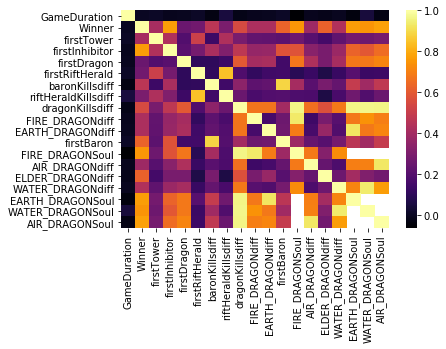

In [159]:
sns.heatmap(df_clean.corr(), cmap = 'inferno')

In [164]:
enc_gamestate_by_time_dict[10]['Winner']

3411673088   -1
3435528193    1
3447586821    1
3426877449   -1
3419144205   -1
             ..
3444742545   -1
3424164242    1
3405814162   -1
3419838867    1
3447495054   -1
Name: Winner, Length: 20012, dtype: int64

In [168]:
df_ini_timecorr = pd.DataFrame()
for time in enc_gamestate_by_time_dict.keys():
    s_corr = pd.Series(enc_gamestate_by_time_dict[time].corrwith(enc_gamestate_by_time_dict[time]['Winner']).drop('Winner'), name=time)
    df_ini_timecorr = pd.concat((df_ini_timecorr, s_corr), axis=1)

In [169]:
df_ini_timecorr

,10,15,20,25,30,35
AIR_DRAGONdiff,0.191492,0.243416,0.264763,0.233516,0.185378,0.134505
WATER_DRAGONdiff,0.316650,0.321824,0.325857,0.290281,0.234705,0.178456
RIFTHERALDdiff,0.189807,0.231883,0.286865,0.208725,0.107054,0.022551
BARON_NASHORdiff,NaN,0.062523,0.051695,0.350548,0.340814,0.224869
FIRE_DRAGONdiff,0.278077,0.286979,0.291128,0.279099,0.215613,0.181457
EARTH_DRAGONdiff,0.260551,0.300264,0.319744,0.280518,0.247665,0.201333
FIRE_DRAGONSoulteam,NaN,1.000000,0.651711,0.725939,0.665715,0.540347
AIR_DRAGONSoulteam,NaN,0.577350,0.874957,0.767002,0.673871,0.440671
WATER_DRAGONSoulteam,NaN,NaN,0.700551,0.755725,0.717088,0.488462
EARTH_DRAGONSoulteam,NaN,NaN,0.594028,0.849271,0.693035,0.605013


Text(0.5, 15.0, 'Match time (min)')

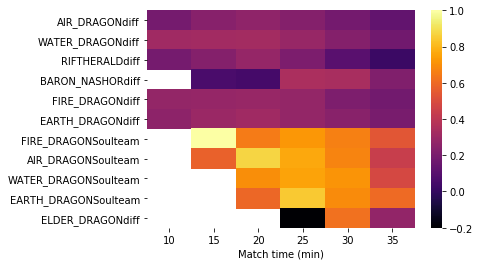

In [176]:
ax = sns.heatmap(df_ini_timecorr, cmap = 'inferno')
ax.set_xlabel('Match time (min)')

Heatmap of correlation of the features with the match winner, for each time interval. Very interesting how high the correlations are for dragon souls with the winner. Infernal soul actually has a correlation coefficient of 1 at 15 minutes. The souls' association with the winning team decreases past 30 minutes, but is still fairly strongly associated with winning with coefficients between 0.44 and 0.61.

In [923]:
df['firstDragon'].value_counts()

red     8675
blue    7705
Name: firstDragon, dtype: int64

#### Imputing

In [28]:
df_filled = df_clean.fillna(df_clean.mean())

In [74]:
filled_gamestate_by_time_dict = {}
#convert blue and red team to boolean ints
for time in enc_gamestate_by_time_dict.keys():
    #df = df.replace({'blue': 0, 'red': 1})
    filled_gamestate_by_time_dict[time] = enc_gamestate_by_time_dict[time].fillna(enc_gamestate_by_time_dict[time].mean())

In [75]:
filled_gamestate_by_time_dict[10]

,Winner,AIR_DRAGONdiff,WATER_DRAGONdiff,RIFTHERALDdiff,BARON_NASHORdiff,FIRE_DRAGONdiff,EARTH_DRAGONdiff
3411673088,-1,-0.078523,-0.037923,0.080762,0.0,-0.047194,-0.022106
3435528193,1,-0.078523,-0.037923,0.080762,0.0,-0.047194,-0.022106
3447586821,1,-1.000000,-0.037923,0.080762,0.0,-0.047194,-0.022106
3426877449,-1,-0.078523,-1.000000,-1.000000,0.0,-0.047194,-0.022106
3419144205,-1,-0.078523,-0.037923,0.080762,0.0,-1.000000,-0.022106
...,...,...,...,...,...,...,...
3444742545,-1,-0.078523,-0.037923,0.080762,0.0,-1.000000,-0.022106
3424164242,1,-0.078523,-0.037923,0.080762,0.0,-0.047194,1.000000
3405814162,-1,-0.078523,-0.037923,0.080762,0.0,1.000000,-0.022106
3419838867,1,-0.078523,-0.037923,0.080762,0.0,-0.047194,1.000000


# Revised Model

My original data had separate sets of features for each team and time features for each objective in an attempt to preserve features. As I found no significant difference in maintaining separate team features, thus I chose to combine the separate team features for ease of results interpretation. For the revised data and model. I combined the teams' metrics by subtracting the red team from the blue team.

In [38]:
X = df_filled.drop('Winner', axis=1)

In [39]:
y = df_filled['Winner']

In [40]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

#### Model selection

Why ensemble learning classifiers:
- works quickly and efficiently for large datasets
- high accuracy for complex datasets

Model of choice, Gradient Boosting Classifier, uses a loss function and weak learner decision trees. The weak learners are added to each other 

In [330]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('ADA', AdaBoostClassifier()))
models.append(('BAG', BaggingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = KFold(n_splits=10, random_state=seed)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ADA: 0.891745 (0.006074)
BAG: 0.874975 (0.005032)
RFC: 0.884452 (0.004338)
GBC: 0.899385 (0.004823)
Wall time: 32.4 s


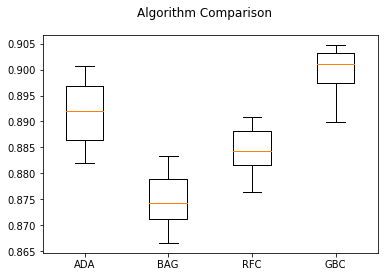

In [331]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Just like with the initial model, GradientBoostingClassifier performed the best amongst the classifers with an accuracy score of 90% and F-score of 0.899.

#### Model tuning

First tried GridSearchCV with small number of parameters, which did not optimize model (and in fact worsened performance slightly). Subsequently used more parameters with RandomSearchCV which produced a slightly improved model.

|                	| Initial Model 	| Optimised Model 	|
|----------------	|---------------	|-----------------	|
| Accuracy Score 	|     0.9044    	| 0.9051          	|
| F-score        	| 0.8994        	| 0.9007          	|

In [65]:
%%time
# Initialize the classifier
clf_GB = GradientBoostingClassifier(random_state = 42)

# Create the parameters list to tune
#parameters = {'n_estimators':[10, 20, 60, 100], 'learning_rate': [0.05, 0.1, 0.2, 1]}

parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf_GB, param_grid = parameters, scoring = scorer, cv = 5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_GB.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9044
F-score on testing data: 0.8994

Optimized Model
------
Final accuracy score on the testing data: 0.8857
Final F-score on the testing data: 0.9031


In [69]:
%%time
clf = GradientBoostingClassifier()

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

params = {"max_depth": [3, None],
              "max_features": range(1, 9),
              "min_samples_leaf": range(1, 9),
              "criterion": ["gini", "friedman_mse"],
                'n_estimators':[10, 20, 60, 100], 
                'learning_rate': [0.05, 0.01, 0.1, 0.2, 1],
                'max_depth': [None, 1, 3, 5, 10]}

'''
#Another set of parameters to use
params = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
'''
random_search = RandomizedSearchCV(clf, param_distributions=params,n_iter=4, scoring=scorer)
random_search.fit(X_train, y_train)


#store optimized clf
best_clf = random_search.best_estimator_

predictions = clf.fit(X_train, y_train).predict(X_test)
best_predictions = best_clf.predict(X_test)
print("Unoptimized model\n------")
print(classification_report(y_test, predictions))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print(classification_report(y_test, best_predictions))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
              precision    recall  f1-score   support

          -1       0.91      0.90      0.91      3109
           1       0.90      0.91      0.90      2938

    accuracy                           0.90      6047
   macro avg       0.90      0.90      0.90      6047
weighted avg       0.90      0.90      0.90      6047

Accuracy score on testing data: 0.9044
F-score on testing data: 0.8994

Optimized Model
------
              precision    recall  f1-score   support

          -1       0.91      0.90      0.91      3109
           1       0.90      0.91      0.90      2938

    accuracy                           0.91      6047
   macro avg       0.90      0.91      0.91      6047
weighted avg       0.91      0.91      0.91      6047

Final accuracy score on the testing data: 0.9051
Final F-score on the testing data: 0.9007
Wall time: 10.8 s


In [180]:
def train_time_series():
    '''
    Trains estimator to predict match winner based on data of captured neutral objectives up to set time intervals.
    Outputs performance metrics,Fbeta_score and accuracy score, and feature importances.
    
    '''
    feat_imp_by_time_df = pd.DataFrame()
    scores_by_time_df = pd.DataFrame(index=[x for x in filled_gamestate_by_time_dict.keys()], 
                                     columns=['F-score', 'Accuracy'])
    for time in list(filled_gamestate_by_time_dict.keys()):
        X = filled_gamestate_by_time_dict[time].drop('Winner', axis=1)
        y = filled_gamestate_by_time_dict[time]['Winner']
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
        best_clf.fit(X_train, y_train)
        y_preds = best_clf.predict(X_test)
        
        s_feat_imp = pd.Series(best_clf.feature_importances_, index=X.columns.values, name=time).sort_values(ascending=False)
        feat_imp_by_time_df = pd.concat((feat_imp_by_time_df, s_feat_imp), axis=1)
        
        scores_by_time_df['F-score'][time] = fbeta_score(y_test, y_preds, beta = 0.5)
        scores_by_time_df['Accuracy'][time] = accuracy_score(y_test, y_preds)

    return feat_imp_by_time_df, scores_by_time_df.astype(float)

In [178]:
%%time
feat_imp_by_time_df, scores_by_time_df = train_time_series()

Wall time: 3.76 s


In [120]:
feat_imp_by_time_df

,10,15,20,25,30,35
WATER_DRAGONdiff,0.299001,0.203074,0.211798,0.140192,0.116853,0.097120
FIRE_DRAGONdiff,0.274889,0.189322,0.162145,0.149741,0.143867,0.099195
EARTH_DRAGONdiff,0.217706,0.201837,0.203155,0.161219,0.129570,0.135436
AIR_DRAGONdiff,0.130932,0.135262,0.130543,0.107321,0.115742,0.111016
RIFTHERALDdiff,0.077472,0.221196,0.252760,0.134774,0.118129,0.143125
BARON_NASHORdiff,0.000000,0.047827,0.031107,0.283870,0.300873,0.214265
AIR_DRAGONSoulteam,NaN,0.000860,0.002792,0.006717,0.019206,0.025089
FIRE_DRAGONSoulteam,NaN,0.000621,0.002530,0.005143,0.012605,0.053519
ELDER_DRAGONdiff,NaN,0.000000,0.000000,0.001764,0.011231,0.042576
EARTH_DRAGONSoulteam,NaN,0.000000,0.001565,0.004658,0.012433,0.032578


In [179]:
scores_by_time_df

,F-score,Accuracy
10,0.532248,0.580446
15,0.613754,0.630252
20,0.679688,0.675913
25,0.710488,0.705388
30,0.696319,0.698388
35,0.705394,0.665914


Text(0.5, 1.0, 'Predicting wins based on cumulative objectives discrepancies at different time intervals')

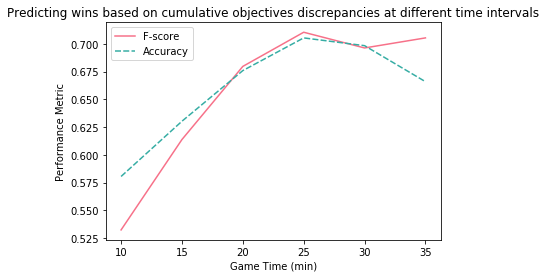

In [186]:
ax = sns.lineplot(data=scores_by_time_df, palette="husl")

ax.set_ylabel("Performance Metric")
ax.set_xlabel("Game Time (min)")
plt.title('Predicting wins based on cumulative objectives discrepancies at different time intervals')
#plt.tight_layout(h_pad=2)

As to be expected, prediction accuracy is little better than random during early game when very few objectives are available to be taken, and thus less data available to base predictions upon. As teams capture more objectives throughout the game, the accuracy increases to a maximum of 70.5% at 25 mins and declines thereafter. The decline is also expected since the advantages granted by neutral objectives slowly evens out: the disadvantaged team can use the time in a stalled game to catch up in resources (gold), while gold differences matters less and less as players max out their resource slots.

In [59]:
clf_preset = GradientBoostingClassifier()
saved_params = {'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [60]:
clf_preset.set_params(**saved_params)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=6, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=60,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [365]:
best_clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Feature importances

In [397]:
var_diff = ['baronKillsdiff','riftHeraldKillsdiff', 
                   'dragonKillsdiff', 'FIRE_DRAGONdiff', 'EARTH_DRAGONdiff', 
                   'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff']
var_team = ['firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'firstBaron', 'FIRE_DRAGONSoul', 
              'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul']
var_firsts = ['firstTower', 'firstInhibitor',
       'firstDragon', 'firstRiftHerald', 'firstBaron']
var_dragtypediff = ['FIRE_DRAGONdiff', 'EARTH_DRAGONdiff', 
                   'AIR_DRAGONdiff', 'ELDER_DRAGONdiff', 'WATER_DRAGONdiff']
var_soul = ['FIRE_DRAGONSoul', 
              'EARTH_DRAGONSoul', 'WATER_DRAGONSoul', 'AIR_DRAGONSoul']

In [368]:
feat_importances = pd.Series(best_clf.feature_importances_, index=X_test.columns.values).sort_values(ascending=False)

In [369]:
feat_importances

firstInhibitor         0.428574
dragonKillsdiff        0.194438
GameDuration           0.100819
baronKillsdiff         0.082527
firstBaron             0.035316
firstTower             0.035183
riftHeraldKillsdiff    0.018968
FIRE_DRAGONdiff        0.016897
firstDragon            0.015536
EARTH_DRAGONdiff       0.014207
AIR_DRAGONdiff         0.013353
WATER_DRAGONdiff       0.013240
firstRiftHerald        0.012784
ELDER_DRAGONdiff       0.007782
FIRE_DRAGONSoul        0.002904
AIR_DRAGONSoul         0.002528
EARTH_DRAGONSoul       0.002499
WATER_DRAGONSoul       0.002447
dtype: float64

In [ ]:
def plot_barh(s_to_plot, title = '', xlabel = '', ylabel = '',
color_palette = 'YlGnBu', pre_unit = '', suff_unit = '', round_place = 4,
              xllim_set = 0, xulim_set = 1, size=(12, 8)):

    y_labels = s_to_plot.index

    # Plot the figure.
    plt.figure(figsize=size)
    ax = s_to_plot.plot(kind='barh')
    plt.barh(s_to_plot.index, s_to_plot,
            color = sns.color_palette(color_palette, len(s_to_plot.index)))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels(y_labels)
    #x_llim, x_ulim = ax.get_xlim()
    #x_ulim = xulim_set
    ax.set_xlim(xllim_set, xulim_set) # expand xlim to make labels easier to read
    plt.tight_layout()
    rects = ax.patches

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        label_string = "{:."+str(round_place)+"f}"
        # Use X value as label and format number with a defined number of decimal places
        #label = "{:.1f}".format(x_value)
        label = label_string.format(x_value)

        # Create annotation
        plt.annotate(
            pre_unit+label+suff_unit,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.

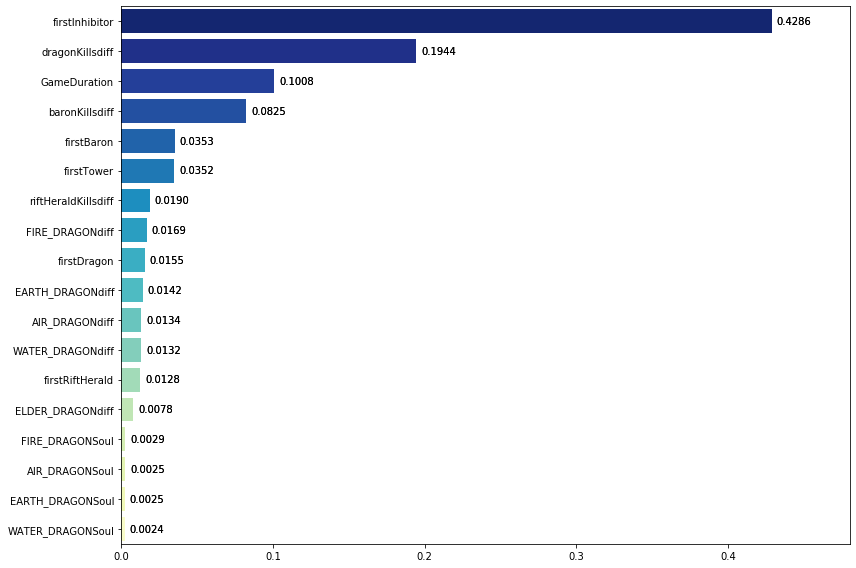

In [410]:
v.plot_barh(feat_importances.sort_values(ascending=True), xulim_set=0.48, round_place=4)

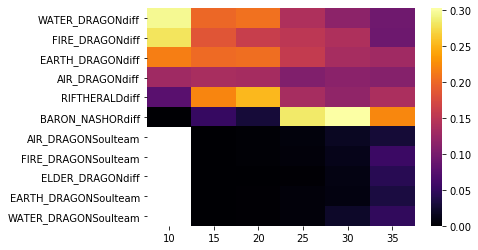

In [158]:
sns.heatmap(feat_imp_by_time_df, cmap = 'inferno')

Different types of objectives seem to be the most valuable (associated with winning) at different points in the game:
- 10 mins: **elemental dragon differences**, in order of Ocean > Infernal > Mountain > Cloud. While this may suggest that the order is related to the degree of advantage the dragon bestows on a team, it's just as possible that the order reflects prioritization of the dragon types. For example, the ocean dragons are regarded as beneficial for early laning phases, so advantaged team may expend more effort securing the dragon than for a cloud dragon.
- 15-20 mins: **rift herald difference** - if the rift herald is captured early enough, it will spawn a second time as a stronger buff. The rift herald will despawn at 20 minutes if not killed, so the window of most significance during 15 and 20 minutes reflects this nicely. The 20 minute association is stronger than the 15 minute one in accordance with the rift herald's strength.
- 25-35 mins: **Baron nashor difference** at 35 mins, soul dragons and elder dragons become more significant, but their effects are still overshadowed by literally every other objective. 

It seems that elemental dragon advantages - those found in early game - are much more significantly associated with wins than souls. Certainly part of the reason for the association may be the translation of early game advantages, obtained from outside of neutral objectives (e.g. lane dominance, successful skirmishes), into capturing neutral objectives. There is still the logical possibility of a causal relationship. 

Individiual elemental dragons might be weak (and they are far weaker than in previous seasons), but they are far more significantly related to wins than the objectively stronger elder dragons and dragon souls. The small advantages conferred by individual drakes in the early game might help teams dominate over the enemy team and snowball further advantages.
To better establish a causal relationship, Assessing how teams prioritize between the different objectives would be useful to establish a causal relationship.

Rift herald seem to be the most significantly associated 

Elemental dragon differences seem to be 

# Results

# Initial Data and Model

In [708]:
#functions used to create the first df and model which predicts winners based on post-game stats
%%time
for gameId in matchlist[:20000]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    #store bool params in match details
    for param in bool_params:
        if match_detail['teams'][0][param] == True:
            match_stats[param] = 'blue'
        elif match_detail['teams'][1][param] == True:
            match_stats[param] = 'red'

    #store num params in match details
    for param in num_params:
        match_stats['blue'+param] = match_detail['teams'][0][param]
        match_stats['red'+param] = match_detail['teams'][1][param]


    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    match_obj_dict[gameId] = match_obj
    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:
            
            #store team+timestamp of any elder dragons
            elder_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] == 'ELDER_DRAGON'].reset_index()
            for row_idx, row in elder_drag_df.iterrows():
                match_stats[str(row_idx+1)+'ELDER_DRAGONteam'] = row['team']
                match_stats[str(row_idx+1)+'ELDER_DRAGONtime'] = row['timestamp']
            
            elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()
            #store total# of elemental drakes on each team, soul dragon info, and # of types of drakes for each team
            for side in ['blue', 'red']:
                match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
                if match_stats[side+'ElemDragNum'] == 4:
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soulteam'] = side
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soultime'] = elem_drag_df[elem_drag_df['team'] == side].reset_index()['timestamp'][3]
                for drag_elem in list(elem_drag_df['DragElement'].unique()):
                    match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]

            for row_idx, row in elem_drag_df.iterrows():
                match_stats[str(row_idx+1)+str(row['DragElement'])+'team'] = row['team']
                match_stats[str(row_idx+1)+str(row['DragElement'])+'time'] = row['timestamp']

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons killed
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()

                #for each herald/baron, extract the team that killed the objective and the time it occured
                for row_idx, row in obj_type_df.iterrows():
                    match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
                    match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    
    match_stats_dict3 [gameId] = match_stats

Wall time: 12min 42s


take out all time vars

In [982]:
X.columns.values

array(['GameDuration', 'firstTower', 'firstInhibitor', 'firstDragon',
       'firstRiftHerald', 'bluebaronKills', 'redbaronKills',
       'blueriftHeraldKills', 'redriftHeraldKills', 'bluedragonKills',
       'reddragonKills', 'blueElemDragNum', 'blueFIRE_DRAGON',
       'blueEARTH_DRAGON', 'redElemDragNum', 'redFIRE_DRAGON',
       'redEARTH_DRAGON', '1FIRE_DRAGONteam', '1FIRE_DRAGONtime',
       '2EARTH_DRAGONteam', '2EARTH_DRAGONtime', 'RIFTHERALD1team',
       'RIFTHERALD1time', 'firstBaron', '1ELDER_DRAGONteam',
       '1ELDER_DRAGONtime', 'blueAIR_DRAGON', 'FIRE_DRAGONSoulteam',
       'FIRE_DRAGONSoultime', 'redAIR_DRAGON', '1AIR_DRAGONteam',
       '1AIR_DRAGONtime', '3FIRE_DRAGONteam', '3FIRE_DRAGONtime',
       '4FIRE_DRAGONteam', '4FIRE_DRAGONtime', 'BARON_NASHOR1team',
       'BARON_NASHOR1time', 'blueWATER_DRAGON', 'redWATER_DRAGON',
       '1WATER_DRAGONteam', '1WATER_DRAGONtime', '2WATER_DRAGONteam',
       '2WATER_DRAGONtime', 'RIFTHERALD2team', 'RIFTHERALD2time',
     

In [15]:
drag_df.query('DragElement != "ELDER_DRAGON" and team == @side').shape[0]

2

In [17]:
match_stats_dict

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'FIRE_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'RIFTHERALDdiff': 1,
  'BARON_NASHORdiff': 0},
 3435528193: {'GameDuration': 1516, 'Winner': 'blue'},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'FIRE_DRAGONSoulteam': 'red',
  'AIR_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'FIRE_DRAGONdiff': -2,
  'ELDER_DRAGONdiff': 1,
  'RIFTHERALDdiff': 0,
  'BARON_NASHORdiff': 1},
 3426877449: {'GameDuration': 915,
  'Winner': 'red',
  'WATER_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'RIFTHERALDdiff': -1,
  'BARON_NASHORdiff': 0},
 3419144205: {'GameDuration': 1176,
  'Winner': 'red',
  'FIRE_DRAGONdiff': -1,
  'WATER_DRAGONdiff': -1,
  'RIFTHERALDdiff': 0,
  'BARON_NASHORdiff': 0},
 3428843533: {'GameDuration': 758,
  'Winner': 'red',
  'WATER_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1},
 3433824271: {'GameDuration': 1154,
  'Winner': 'blue',
  'FIRE_DRAGONdiff': 1,
  'WATER_DRAGONdiff': -1,
  'AIR_DRAGONdiff': 0,
  'RIF

In [996]:
match_timeline_dict[gameId].keys()

dict_keys(['frames', 'frameInterval'])

In [709]:
#convert dict into df with one game per row
df = pd.DataFrame(match_stats_dict3).transpose()

In [806]:
var_soul = ['FIRE_DRAGONSoulteam', 'FIRE_DRAGONSoultime',
            'WATER_DRAGONSoulteam', 'WATER_DRAGONSoultime',
           'AIR_DRAGONSoulteam', 'AIR_DRAGONSoultime',
           'EARTH_DRAGONSoulteam', 'EARTH_DRAGONSoultime']
var_soul_team = ['FIRE_DRAGONSoulteam', 
            'WATER_DRAGONSoulteam', 
           'AIR_DRAGONSoulteam', 
           'EARTH_DRAGONSoulteam']
var_soul_time = ['FIRE_DRAGONSoultime',
'WATER_DRAGONSoultime',
'AIR_DRAGONSoultime',
'EARTH_DRAGONSoultime']

In [982]:
X.columns.values

array(['GameDuration', 'firstTower', 'firstInhibitor', 'firstDragon',
       'firstRiftHerald', 'bluebaronKills', 'redbaronKills',
       'blueriftHeraldKills', 'redriftHeraldKills', 'bluedragonKills',
       'reddragonKills', 'blueElemDragNum', 'blueFIRE_DRAGON',
       'blueEARTH_DRAGON', 'redElemDragNum', 'redFIRE_DRAGON',
       'redEARTH_DRAGON', '1FIRE_DRAGONteam', '1FIRE_DRAGONtime',
       '2EARTH_DRAGONteam', '2EARTH_DRAGONtime', 'RIFTHERALD1team',
       'RIFTHERALD1time', 'firstBaron', '1ELDER_DRAGONteam',
       '1ELDER_DRAGONtime', 'blueAIR_DRAGON', 'FIRE_DRAGONSoulteam',
       'FIRE_DRAGONSoultime', 'redAIR_DRAGON', '1AIR_DRAGONteam',
       '1AIR_DRAGONtime', '3FIRE_DRAGONteam', '3FIRE_DRAGONtime',
       '4FIRE_DRAGONteam', '4FIRE_DRAGONtime', 'BARON_NASHOR1team',
       'BARON_NASHOR1time', 'blueWATER_DRAGON', 'redWATER_DRAGON',
       '1WATER_DRAGONteam', '1WATER_DRAGONtime', '2WATER_DRAGONteam',
       '2WATER_DRAGONtime', 'RIFTHERALD2team', 'RIFTHERALD2time',
     

In [807]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,1,1.0,1.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,0,0.0,1.0,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,0,1.0,1.0,1.0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,1,1.0,NaN,1.0,1.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,1,1.0,1.0,1.0,0.0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,1,1.0,1.0,1.0,1.0,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,0,0.0,0.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,1,0.0,1.0,0.0,0.0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,1,1.0,NaN,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [814]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.DataFrame.count()

In [847]:
for var in var_soul_team:
    print (df[var].value_counts())

red     518
blue    433
Name: FIRE_DRAGONSoulteam, dtype: int64
red     539
blue    468
Name: WATER_DRAGONSoulteam, dtype: int64
red     521
blue    423
Name: AIR_DRAGONSoulteam, dtype: int64
red     541
blue    461
Name: EARTH_DRAGONSoulteam, dtype: int64


In [859]:
df[var_soul_team]

,FIRE_DRAGONSoulteam,WATER_DRAGONSoulteam,AIR_DRAGONSoulteam,EARTH_DRAGONSoulteam
3411673088,NaN,NaN,NaN,NaN
3435528193,NaN,NaN,NaN,NaN
3447586821,red,NaN,NaN,NaN
3426877449,NaN,NaN,NaN,NaN
3419144205,NaN,NaN,NaN,NaN
...,...,...,...,...
3436877728,NaN,NaN,NaN,NaN
3422984098,NaN,NaN,NaN,NaN
3342243749,NaN,NaN,NaN,NaN
3448805286,NaN,NaN,NaN,NaN


In [857]:
df['FIRE_DRAGONSoulteam'].replace(np.nan, '').str.cat(df['WATER_DRAGONSoulteam'].replace(np.nan, ''))

3411673088       
3435528193       
3447586821    red
3426877449       
3419144205       
             ... 
3436877728       
3422984098       
3342243749       
3448805286       
3427833767       
Name: FIRE_DRAGONSoulteam, Length: 20000, dtype: object

In [866]:
pd.Series(df['FIRE_DRAGONSoulteam'].replace(np.nan, '').astype(str) + df['WATER_DRAGONSoulteam'].replace(np.nan, '').astype(str))

3411673088       
3435528193       
3447586821    red
3426877449       
3419144205       
             ... 
3436877728       
3422984098       
3342243749       
3448805286       
3427833767       
Length: 20000, dtype: object

In [895]:
#create new var of which team obtained dragon soul
s = df[var_soul_team[0]]
for var in var_soul_team[1:]:
    s = s.replace(np.nan, '').astype(str).add(df[var].replace(np.nan, '').astype(str))

In [901]:
s.replace({'':np.nan, 'blue': 0, 'red': 1})

3411673088    NaN
3435528193    NaN
3447586821    1.0
3426877449    NaN
3419144205    NaN
             ... 
3436877728    NaN
3422984098    NaN
3342243749    NaN
3448805286    NaN
3427833767    NaN
Length: 20000, dtype: float64

In [904]:
df['soul_team'] = s.replace({'':np.nan})

In [907]:
df['GameDuration'].max()

3507

In [905]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time,soul_team
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,red
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
match_stats = {}

In [713]:
df_clean = df[df['GameDuration'] > 300]

In [714]:
df_dropped

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [911]:
#drop games below 3min in length - not relevant since they would be remakes
df_clean = df[df['GameDuration'] > 300].replace({'blue':0, 'red':1})

In [912]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time,soul_team
3411673088,1195,1,1.0,1.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,0,0.0,1.0,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,0,1.0,1.0,1.0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3426877449,915,1,1.0,NaN,1.0,1.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,1,1.0,1.0,1.0,0.0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,1,1.0,1.0,1.0,1.0,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,0,0.0,0.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,1,0.0,1.0,0.0,0.0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,1,1.0,NaN,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [913]:
df_filled = df_clean.fillna(df_clean.mean())

<a id='machine'></a>
### Model Selection

In [925]:
X = df_filled.drop('Winner', axis=1)

In [926]:
y = df_filled['Winner']

In [927]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [738]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


LR: 0.510411 (0.008647)
LDA: 0.893824 (0.004370)
KNN: 0.531184 (0.008935)
CART: 0.858566 (0.005077)
NB: 0.490544 (0.005773)
SVM: 0.511719 (0.005898)


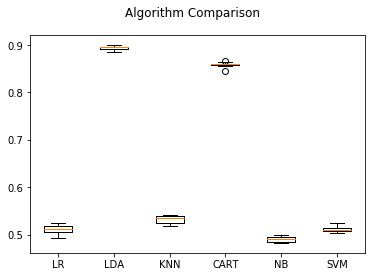

In [739]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Since ensemble method classifers seem promising from the results with DecisionTreeClassifier, train and compare ensemble method classifiers.

In [742]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('ADA', AdaBoostClassifier()))
models.append(('BAG', BaggingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ADA: 0.886380 (0.006614)
BAG: 0.876622 (0.004677)
RFC: 0.888895 (0.004026)
GBC: 0.900564 (0.005460)
Wall time: 2min 16s


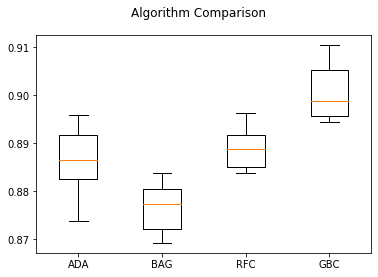

In [744]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<a id='tuning'></a>
### Model Tuning

GradientBoostingClassifier was selected for having the highest precision and f1-score amongst the fitted classifers. GridSearchCCV was used to fine-tune the model parameters.

In [781]:
clf_GB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [928]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf_GB = GradientBoostingClassifier(random_state = 42)

# Create the parameters list to tune
parameters = {'n_estimators':[10, 20, 60, 100], 'learning_rate': [0.05, 0.1, 0.2, 1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf_GB, param_grid = parameters, scoring = scorer, cv = 5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_GB.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9065
F-score on testing data: 0.9102

Optimized Model
------
Final accuracy score on the testing data: 0.9076
Final F-score on the testing data: 0.9118


### Feature Importance Extraction

In [790]:
feat_importances = pd.Series(clf_GB.feature_importances_, index=X_test.columns.values).sort_values(ascending=False)

In [968]:
def plot_barh(s_to_plot, title = '', xlabel = '', ylabel = '',
color_palette = 'YlGnBu', pre_unit = '', suff_unit = '', round_place = '',):
    '''
    Plot horizontal bar graph
    '''
    y_labels = s_to_plot.index

    # Plot the figure.
    plt.figure(figsize=(12, 20))
    ax = s_to_plot.plot(kind='barh')
    plt.barh(s_to_plot.index, s_to_plot,
            color = sns.color_palette(color_palette, len(s_to_plot.index)))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels(y_labels)
    x_llim, x_ulim = ax.get_xlim()
    #x_ulim = xulim_set
    #ax.set_xlim(x_llim, xulim_set) # expand xlim to make labels easier to read
    plt.tight_layout()
    rects = ax.patches

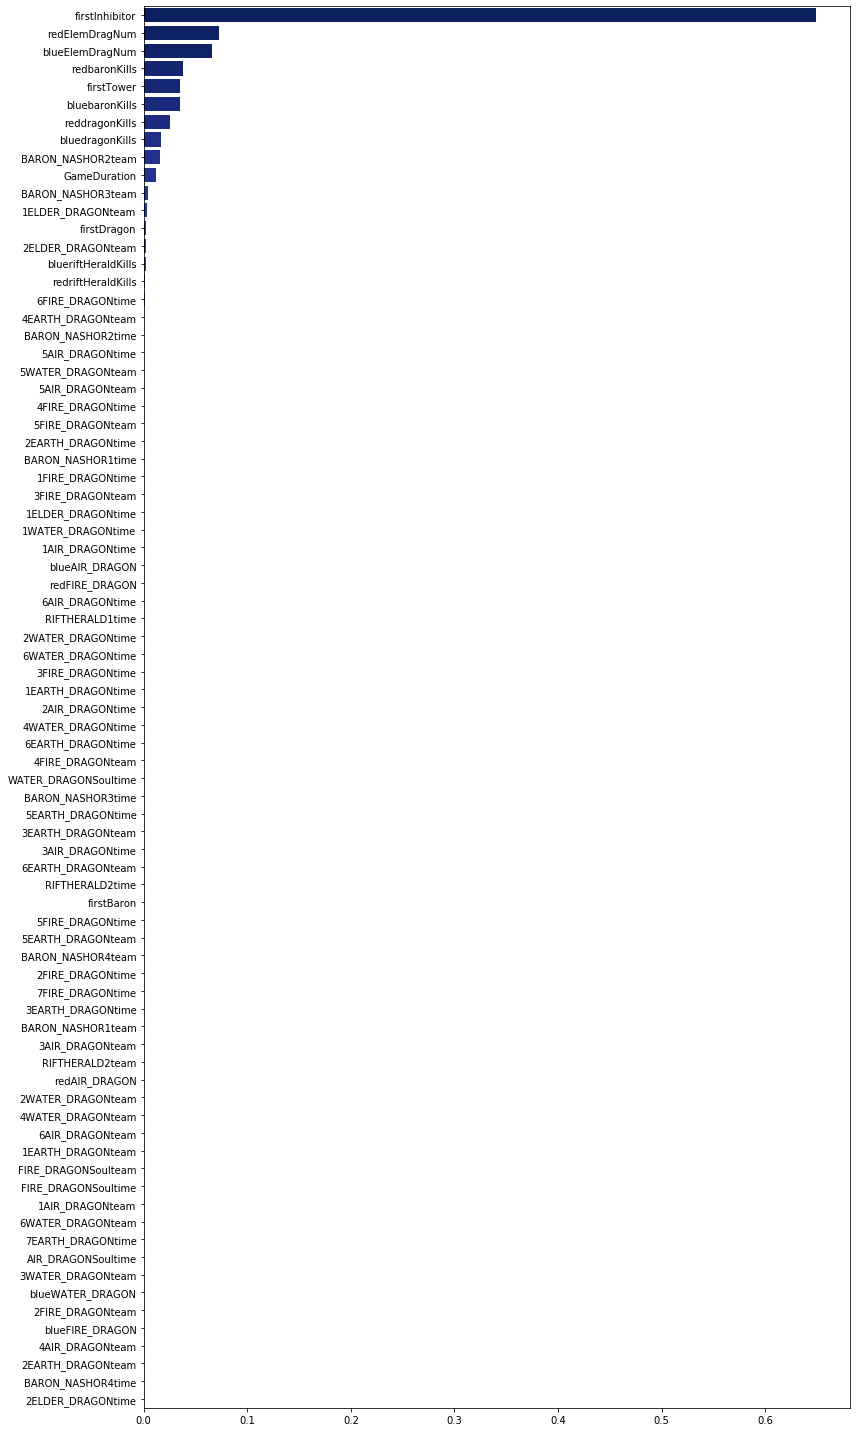

In [969]:
plot_barh(feat_importances[feat_importances > 0].sort_values())

In [971]:
pd.DataFrame(feat_importances[feat_importances > 0])

,0
firstInhibitor,6.489103e-01
redElemDragNum,7.295672e-02
blueElemDragNum,6.624017e-02
redbaronKills,3.830563e-02
firstTower,3.491930e-02
...,...
blueFIRE_DRAGON,1.690759e-05
4AIR_DRAGONteam,2.279306e-06
2EARTH_DRAGONteam,1.420384e-06
BARON_NASHOR4time,1.109049e-06


In [930]:
feat_importances[var_soul].sort_values(ascending=False)

WATER_DRAGONSoultime    0.000300
FIRE_DRAGONSoulteam     0.000099
FIRE_DRAGONSoultime     0.000098
AIR_DRAGONSoultime      0.000041
EARTH_DRAGONSoultime    0.000000
EARTH_DRAGONSoulteam    0.000000
AIR_DRAGONSoulteam      0.000000
WATER_DRAGONSoulteam    0.000000
dtype: float64

In [803]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.2, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [972]:
feat_importances[:30]

firstInhibitor         0.648910
redElemDragNum         0.072957
blueElemDragNum        0.066240
redbaronKills          0.038306
firstTower             0.034919
bluebaronKills         0.034776
reddragonKills         0.025468
bluedragonKills        0.016608
BARON_NASHOR2team      0.015860
GameDuration           0.012358
BARON_NASHOR3team      0.004313
1ELDER_DRAGONteam      0.003248
firstDragon            0.002674
2ELDER_DRAGONteam      0.002267
blueriftHeraldKills    0.001990
redriftHeraldKills     0.001301
6FIRE_DRAGONtime       0.000944
4EARTH_DRAGONteam      0.000799
BARON_NASHOR2time      0.000766
5AIR_DRAGONtime        0.000759
5WATER_DRAGONteam      0.000759
5AIR_DRAGONteam        0.000632
4FIRE_DRAGONtime       0.000627
5FIRE_DRAGONteam       0.000594
2EARTH_DRAGONtime      0.000560
BARON_NASHOR1time      0.000545
1FIRE_DRAGONtime       0.000491
3FIRE_DRAGONteam       0.000465
1ELDER_DRAGONtime      0.000429
1WATER_DRAGONtime      0.000426
dtype: float64

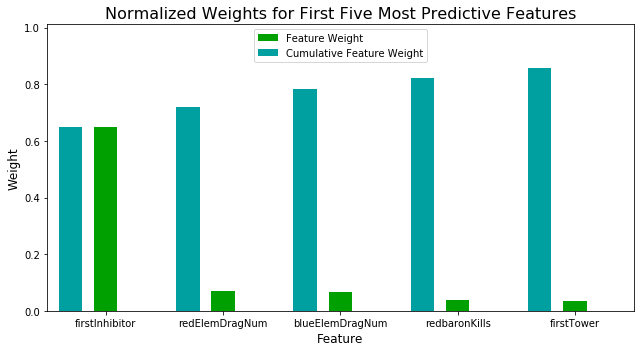

In [931]:
feature_plot(clf_GB.feature_importances_, X_train, y_train)

### Results of initial model

#### Dragon Soul

The data does seem to reflect what people think of the relative power levels of dragon souls - ocean is the most powerful IF you get it early. Cloud soul also contributes towards wins if it's obtained earlier in the game. This makes sense since ocean and cloud drake both grant advantages early and mid-game, but these advantages decrease as the game goes on. Come late game, the players' stats will have scaled enough and the game's pace will change to even out these dragon soul advantages. 

Ocean soul grants extra health and mana regeneration out of combat, which will help one team stay healthy throughout midgames during skirmishes, extended seiges and teamfights. Since it boosts regeneration, ocean soul is only useful if at least some players on a team stay alive after combat. Turrets still do significant damage to players midgame, so even if not everyone on a is alive, ocean soul helps the alive players stay healthy to defend with the safety of  structures. As the game goes on, player damage will have also increased to the point that players are more likely to die and the death timers are longer. Additionally, structural defenses, turrets, do less meaningful damage to players while players can destroy them more easily. As deaths become more impactful, any player who remain alive on a team while some of their teammates are dead find that ocean soul becomes less helpful in defense. 

Cloud soul increases movement speed and cooldown reduction on spells, granting one team a tempo advantage in moving around the map and having increased access to useful ultimate spells. Player will have more CDR items and have decreased cooldowns with higher level spells, so players will be more likely to have equal access to their ultimate spells later in the game. 

Infernal soul, on the other hand, remains powerful regardless of when the team obtains it. The infernal soul grants percent-based permanent damage bonuses to a team, so that advantage remains throughout the course of a game.

The top 5 most predictive features are:
1. team that takes first inhibitor
2. number of elemental dragons taken by red team
3. number of elemental dragons taken by blue team
4. number of baron kills taken by the red team
5. team that takes first tower

Which team kills the first inhibitor seems to be the best predictor of who will win the game. This makes sense since killing an inhibitor is the most direct path towards killing the enemy nexus. The first inhibitor kill accounts for 60% of the weights for predicting the game winner. 

The total number of elemental drakes taken by a team is the next best predictor, with red team dragon kills being slightly more predictive than blue team's. Without doing further analysis it's hard to say whether this difference is statistically significant. We can speculate that perhaps the red team's larger relative distance from the dragon pit compared to the blue team means that red team naturally has less control over the dragon; therefore, if the red team is successful at capturing dragon objectives, red likely has a strong control over the game carrying over to wins.

The order of importance of neutral objectives to the game result seems to be:
#### elemental dragons > baron > elder dragon > rift herald

### Early objectives

Of all the early objectives available (inhibitor, tower, dragon, baron, rift herald), it seems that the non-neutral objectives, inhibitors and towers, are the most predictive, followed by dragon and baron. First rift herald seem to have no predictive weight on the winner at all.

Of course, the associations here must be taken with a grain of salt before tranlating them to causation. Having early game pressure will translate to more objective control. However, it is very telling that first dragon has more weight than first herald, when both of these objectives are usually captured around the same time and are often "traded" for each other (if one team takes one, the other team will take the other).

In [ ]:
bool_params = ['firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald']
num_params = ['baronKills', 'riftHeraldKills', 'dragonKills']

In [979]:
feat_importances[bool_params].sort_values(ascending=False)

firstInhibitor     0.648910
firstTower         0.034919
firstDragon        0.002674
firstBaron         0.000188
firstRiftHerald    0.000000
dtype: float64

# Results Summary

Although this project is unable to establish causal relationships, it identified interesting relationships between different types of neutral objectives, game time, and the winning team:
- among the "firsts" in objectives, first inhibitor is most predictive of the winner followed by first baron and first tower very closely together.

# Future work/directions:
- adding predictions based on different points of time in the game
- try fitting a XGBoost Classifier model, a variation of the Gradient Boosting Classifier used for the project
- add other relevant match variables: team gold, kills, wards, champion picks, etc.
- expand number of matches in dataset - due to time practicality limitations, only 20,000 matches were extracted of over 60,000 match IDs obtained
- expand data to servers in other geographical regions - e.g. EU, China, Korean
- expand data to lower elos, since masters+ is a very small proportion of the playerbase and may not reflect what the predictors are in lower elo (e.g. Bronze, Silver, Gold)
- evaluate competitive play, which plays out differently than solo queue, and where objective decisions matter more than anywhere else

---
---
---

# Initial Data and Model

In [708]:
#functions used to create the first df and model which predicts winners based on post-game stats
%%time
for gameId in matchlist[:20000]:
    
    match_detail = match_detail_dict[gameId] #retrieve game details from dict
    match_stats = {} #initialize dict for game
    #create a key for the game winner
    match_stats['GameDuration'] = match_detail['gameDuration']
    if match_detail['teams'][0]['win'] == 'Win':
        match_stats['Winner'] = 'blue' 
    elif match_detail['teams'][1]['win'] == 'Win':
        match_stats['Winner'] = 'red' 

    #store bool params in match details
    for param in bool_params:
        if match_detail['teams'][0][param] == True:
            match_stats[param] = 'blue'
        elif match_detail['teams'][1][param] == True:
            match_stats[param] = 'red'

    #store num params in match details
    for param in num_params:
        match_stats['blue'+param] = match_detail['teams'][0][param]
        match_stats['red'+param] = match_detail['teams'][1][param]


    match_timeline = match_timeline_dict[gameId]
    #create a key for objective stats
    match_obj = []
    for i in range(len(match_timeline['frames'])):
        for event in match_timeline['frames'][i]['events']:
            #type == 'ELITE_MONSTER_KILL'
            if event['type'] == 'ELITE_MONSTER_KILL':
                if event['killerId'] == 0:
                    pass
                elif event['killerId'] > 0:
                    obj = {}
                    obj['ObjectiveType'] = event['monsterType']
                    if event['monsterType'] == 'DRAGON':
                        obj['DragElement'] = event['monsterSubType']
                    obj['timestamp'] = event['timestamp']
                    if 1<= event['killerId'] <= 5:
                        obj['team'] = 'blue'
                    elif 6<= event['killerId'] <= 10:
                        obj['team'] = 'red'
                    match_obj.append(obj)

    match_obj_dict[gameId] = match_obj
    if len(match_obj) > 0:
        obj_timeline_df = pd.DataFrame(match_obj)

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] == 'DRAGON'].shape[0] > 0:
            
            #store team+timestamp of any elder dragons
            elder_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] == 'ELDER_DRAGON'].reset_index()
            for row_idx, row in elder_drag_df.iterrows():
                match_stats[str(row_idx+1)+'ELDER_DRAGONteam'] = row['team']
                match_stats[str(row_idx+1)+'ELDER_DRAGONtime'] = row['timestamp']
            
            elem_drag_df = obj_timeline_df[obj_timeline_df['DragElement'] != 'ELDER_DRAGON'].dropna(axis=0).reset_index()
            #store total# of elemental drakes on each team, soul dragon info, and # of types of drakes for each team
            for side in ['blue', 'red']:
                match_stats[side+'ElemDragNum'] = elem_drag_df[elem_drag_df['team'] == side].shape[0]
                if match_stats[side+'ElemDragNum'] == 4:
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soulteam'] = side
                    match_stats[str(elem_drag_df['DragElement'][2])+'Soultime'] = elem_drag_df[elem_drag_df['team'] == side].reset_index()['timestamp'][3]
                for drag_elem in list(elem_drag_df['DragElement'].unique()):
                    match_stats[str(side+drag_elem)] = elem_drag_df.query('DragElement == @drag_elem and team == @side').shape[0]

            for row_idx, row in elem_drag_df.iterrows():
                match_stats[str(row_idx+1)+str(row['DragElement'])+'team'] = row['team']
                match_stats[str(row_idx+1)+str(row['DragElement'])+'time'] = row['timestamp']

        if obj_timeline_df[obj_timeline_df['ObjectiveType'] != 'DRAGON'].shape[0] > 0:
            #store details about rift heralds and barons killed
            for obj_type in ['RIFTHERALD', 'BARON_NASHOR']:
                #slice the df with the relevant objective
                obj_type_df = obj_timeline_df[obj_timeline_df['ObjectiveType'] == obj_type].reset_index()

                #for each herald/baron, extract the team that killed the objective and the time it occured
                for row_idx, row in obj_type_df.iterrows():
                    match_stats[str(obj_type+str(row_idx+1)+'team')] = obj_type_df['team'][row_idx]
                    match_stats[str(obj_type+str(row_idx+1)+'time')] = obj_type_df['timestamp'][row_idx]
    
    match_stats_dict3 [gameId] = match_stats

Wall time: 12min 42s


take out all time vars

In [982]:
X.columns.values

array(['GameDuration', 'firstTower', 'firstInhibitor', 'firstDragon',
       'firstRiftHerald', 'bluebaronKills', 'redbaronKills',
       'blueriftHeraldKills', 'redriftHeraldKills', 'bluedragonKills',
       'reddragonKills', 'blueElemDragNum', 'blueFIRE_DRAGON',
       'blueEARTH_DRAGON', 'redElemDragNum', 'redFIRE_DRAGON',
       'redEARTH_DRAGON', '1FIRE_DRAGONteam', '1FIRE_DRAGONtime',
       '2EARTH_DRAGONteam', '2EARTH_DRAGONtime', 'RIFTHERALD1team',
       'RIFTHERALD1time', 'firstBaron', '1ELDER_DRAGONteam',
       '1ELDER_DRAGONtime', 'blueAIR_DRAGON', 'FIRE_DRAGONSoulteam',
       'FIRE_DRAGONSoultime', 'redAIR_DRAGON', '1AIR_DRAGONteam',
       '1AIR_DRAGONtime', '3FIRE_DRAGONteam', '3FIRE_DRAGONtime',
       '4FIRE_DRAGONteam', '4FIRE_DRAGONtime', 'BARON_NASHOR1team',
       'BARON_NASHOR1time', 'blueWATER_DRAGON', 'redWATER_DRAGON',
       '1WATER_DRAGONteam', '1WATER_DRAGONtime', '2WATER_DRAGONteam',
       '2WATER_DRAGONtime', 'RIFTHERALD2team', 'RIFTHERALD2time',
     

In [15]:
drag_df.query('DragElement != "ELDER_DRAGON" and team == @side').shape[0]

2

In [17]:
match_stats_dict

{3411673088: {'GameDuration': 1195,
  'Winner': 'red',
  'FIRE_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'RIFTHERALDdiff': 1,
  'BARON_NASHORdiff': 0},
 3435528193: {'GameDuration': 1516, 'Winner': 'blue'},
 3447586821: {'GameDuration': 1964,
  'Winner': 'blue',
  'FIRE_DRAGONSoulteam': 'red',
  'AIR_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'FIRE_DRAGONdiff': -2,
  'ELDER_DRAGONdiff': 1,
  'RIFTHERALDdiff': 0,
  'BARON_NASHORdiff': 1},
 3426877449: {'GameDuration': 915,
  'Winner': 'red',
  'WATER_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1,
  'RIFTHERALDdiff': -1,
  'BARON_NASHORdiff': 0},
 3419144205: {'GameDuration': 1176,
  'Winner': 'red',
  'FIRE_DRAGONdiff': -1,
  'WATER_DRAGONdiff': -1,
  'RIFTHERALDdiff': 0,
  'BARON_NASHORdiff': 0},
 3428843533: {'GameDuration': 758,
  'Winner': 'red',
  'WATER_DRAGONdiff': -1,
  'EARTH_DRAGONdiff': -1},
 3433824271: {'GameDuration': 1154,
  'Winner': 'blue',
  'FIRE_DRAGONdiff': 1,
  'WATER_DRAGONdiff': -1,
  'AIR_DRAGONdiff': 0,
  'RIF

In [996]:
match_timeline_dict[gameId].keys()

dict_keys(['frames', 'frameInterval'])

In [709]:
#convert dict into df with one game per row
df = pd.DataFrame(match_stats_dict3).transpose()

In [806]:
var_soul = ['FIRE_DRAGONSoulteam', 'FIRE_DRAGONSoultime',
            'WATER_DRAGONSoulteam', 'WATER_DRAGONSoultime',
           'AIR_DRAGONSoulteam', 'AIR_DRAGONSoultime',
           'EARTH_DRAGONSoulteam', 'EARTH_DRAGONSoultime']
var_soul_team = ['FIRE_DRAGONSoulteam', 
            'WATER_DRAGONSoulteam', 
           'AIR_DRAGONSoulteam', 
           'EARTH_DRAGONSoulteam']
var_soul_time = ['FIRE_DRAGONSoultime',
'WATER_DRAGONSoultime',
'AIR_DRAGONSoultime',
'EARTH_DRAGONSoultime']

In [982]:
X.columns.values

array(['GameDuration', 'firstTower', 'firstInhibitor', 'firstDragon',
       'firstRiftHerald', 'bluebaronKills', 'redbaronKills',
       'blueriftHeraldKills', 'redriftHeraldKills', 'bluedragonKills',
       'reddragonKills', 'blueElemDragNum', 'blueFIRE_DRAGON',
       'blueEARTH_DRAGON', 'redElemDragNum', 'redFIRE_DRAGON',
       'redEARTH_DRAGON', '1FIRE_DRAGONteam', '1FIRE_DRAGONtime',
       '2EARTH_DRAGONteam', '2EARTH_DRAGONtime', 'RIFTHERALD1team',
       'RIFTHERALD1time', 'firstBaron', '1ELDER_DRAGONteam',
       '1ELDER_DRAGONtime', 'blueAIR_DRAGON', 'FIRE_DRAGONSoulteam',
       'FIRE_DRAGONSoultime', 'redAIR_DRAGON', '1AIR_DRAGONteam',
       '1AIR_DRAGONtime', '3FIRE_DRAGONteam', '3FIRE_DRAGONtime',
       '4FIRE_DRAGONteam', '4FIRE_DRAGONtime', 'BARON_NASHOR1team',
       'BARON_NASHOR1time', 'blueWATER_DRAGON', 'redWATER_DRAGON',
       '1WATER_DRAGONteam', '1WATER_DRAGONtime', '2WATER_DRAGONteam',
       '2WATER_DRAGONtime', 'RIFTHERALD2team', 'RIFTHERALD2time',
     

In [807]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,1,1.0,1.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,0,0.0,1.0,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,0,1.0,1.0,1.0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,1,1.0,NaN,1.0,1.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,1,1.0,1.0,1.0,0.0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,1,1.0,1.0,1.0,1.0,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,0,0.0,0.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,1,0.0,1.0,0.0,0.0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,1,1.0,NaN,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [814]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.DataFrame.count()

In [847]:
for var in var_soul_team:
    print (df[var].value_counts())

red     518
blue    433
Name: FIRE_DRAGONSoulteam, dtype: int64
red     539
blue    468
Name: WATER_DRAGONSoulteam, dtype: int64
red     521
blue    423
Name: AIR_DRAGONSoulteam, dtype: int64
red     541
blue    461
Name: EARTH_DRAGONSoulteam, dtype: int64


In [859]:
df[var_soul_team]

,FIRE_DRAGONSoulteam,WATER_DRAGONSoulteam,AIR_DRAGONSoulteam,EARTH_DRAGONSoulteam
3411673088,NaN,NaN,NaN,NaN
3435528193,NaN,NaN,NaN,NaN
3447586821,red,NaN,NaN,NaN
3426877449,NaN,NaN,NaN,NaN
3419144205,NaN,NaN,NaN,NaN
...,...,...,...,...
3436877728,NaN,NaN,NaN,NaN
3422984098,NaN,NaN,NaN,NaN
3342243749,NaN,NaN,NaN,NaN
3448805286,NaN,NaN,NaN,NaN


In [895]:
#create new var of which team obtained dragon soul
s = df[var_soul_team[0]]
for var in var_soul_team[1:]:
    s = s.replace(np.nan, '').astype(str).add(df[var].replace(np.nan, '').astype(str))

In [904]:
df['soul_team'] = s.replace({'':np.nan})

In [907]:
df['GameDuration'].max()

3507

In [905]:
df

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time,soul_team
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,red
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
match_stats = {}

In [713]:
df_clean = df[df['GameDuration'] > 300]

In [714]:
df_dropped

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONteam,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time
3411673088,1195,red,red,red,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,blue,blue,red,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,blue,red,red,red,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426877449,915,red,red,NaN,red,red,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,red,red,red,red,blue,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,red,red,red,red,red,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,blue,blue,blue,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,red,blue,red,blue,blue,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,red,red,NaN,red,blue,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [911]:
#drop games below 3min in length - not relevant since they would be remakes
df_clean = df[df['GameDuration'] > 300].replace({'blue':0, 'red':1})

In [912]:
df_clean

,GameDuration,Winner,firstTower,firstInhibitor,firstDragon,firstRiftHerald,bluebaronKills,redbaronKills,blueriftHeraldKills,redriftHeraldKills,...,2ELDER_DRAGONtime,7AIR_DRAGONteam,7AIR_DRAGONtime,7WATER_DRAGONteam,7WATER_DRAGONtime,3ELDER_DRAGONteam,3ELDER_DRAGONtime,BARON_NASHOR5team,BARON_NASHOR5time,soul_team
3411673088,1195,1,1.0,1.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435528193,1516,0,0.0,1.0,NaN,NaN,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3447586821,1964,0,1.0,1.0,1.0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3426877449,915,1,1.0,NaN,1.0,1.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419144205,1176,1,1.0,1.0,1.0,0.0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436877728,2184,1,1.0,1.0,1.0,1.0,0,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3422984098,1112,0,0.0,0.0,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342243749,1880,1,0.0,1.0,0.0,0.0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448805286,1105,1,1.0,NaN,1.0,0.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [913]:
df_filled = df_clean.fillna(df_clean.mean())

<a id='machine'></a>
### Model Selection

In [925]:
X = df_filled.drop('Winner', axis=1)

In [926]:
y = df_filled['Winner']

In [927]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [738]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


LR: 0.510411 (0.008647)
LDA: 0.893824 (0.004370)
KNN: 0.531184 (0.008935)
CART: 0.858566 (0.005077)
NB: 0.490544 (0.005773)
SVM: 0.511719 (0.005898)


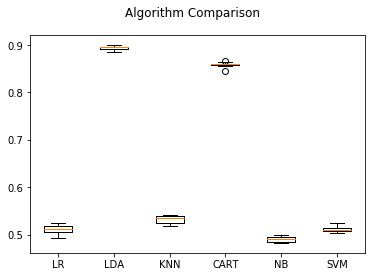

In [739]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Since ensemble method classifers seem promising from the results with DecisionTreeClassifier, train and compare ensemble method classifiers.

In [742]:
%%time
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('ADA', AdaBoostClassifier()))
models.append(('BAG', BaggingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ADA: 0.886380 (0.006614)
BAG: 0.876622 (0.004677)
RFC: 0.888895 (0.004026)
GBC: 0.900564 (0.005460)
Wall time: 2min 16s


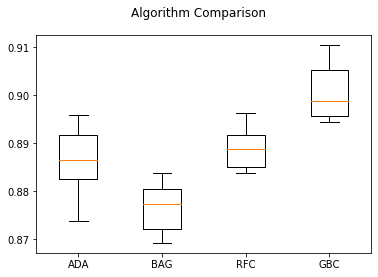

In [744]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<a id='tuning'></a>
### Model Tuning

GradientBoostingClassifier was selected for having the highest precision and f1-score amongst the fitted classifers. GridSearchCCV was used to fine-tune the model parameters.

In [781]:
clf_GB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [928]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf_GB = GradientBoostingClassifier(random_state = 42)

# Create the parameters list to tune
parameters = {'n_estimators':[10, 20, 60, 100], 'learning_rate': [0.05, 0.1, 0.2, 1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf_GB, param_grid = parameters, scoring = scorer, cv = 5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_GB.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9065
F-score on testing data: 0.9102

Optimized Model
------
Final accuracy score on the testing data: 0.9076
Final F-score on the testing data: 0.9118


### Feature Importance Extraction

In [790]:
feat_importances = pd.Series(clf_GB.feature_importances_, index=X_test.columns.values).sort_values(ascending=False)

In [968]:
def plot_barh(s_to_plot, title = '', xlabel = '', ylabel = '',
color_palette = 'YlGnBu', pre_unit = '', suff_unit = '', round_place = '',):
    '''
    Plot horizontal bar graph
    '''
    y_labels = s_to_plot.index

    # Plot the figure.
    plt.figure(figsize=(12, 20))
    ax = s_to_plot.plot(kind='barh')
    plt.barh(s_to_plot.index, s_to_plot,
            color = sns.color_palette(color_palette, len(s_to_plot.index)))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels(y_labels)
    x_llim, x_ulim = ax.get_xlim()
    #x_ulim = xulim_set
    #ax.set_xlim(x_llim, xulim_set) # expand xlim to make labels easier to read
    plt.tight_layout()
    rects = ax.patches

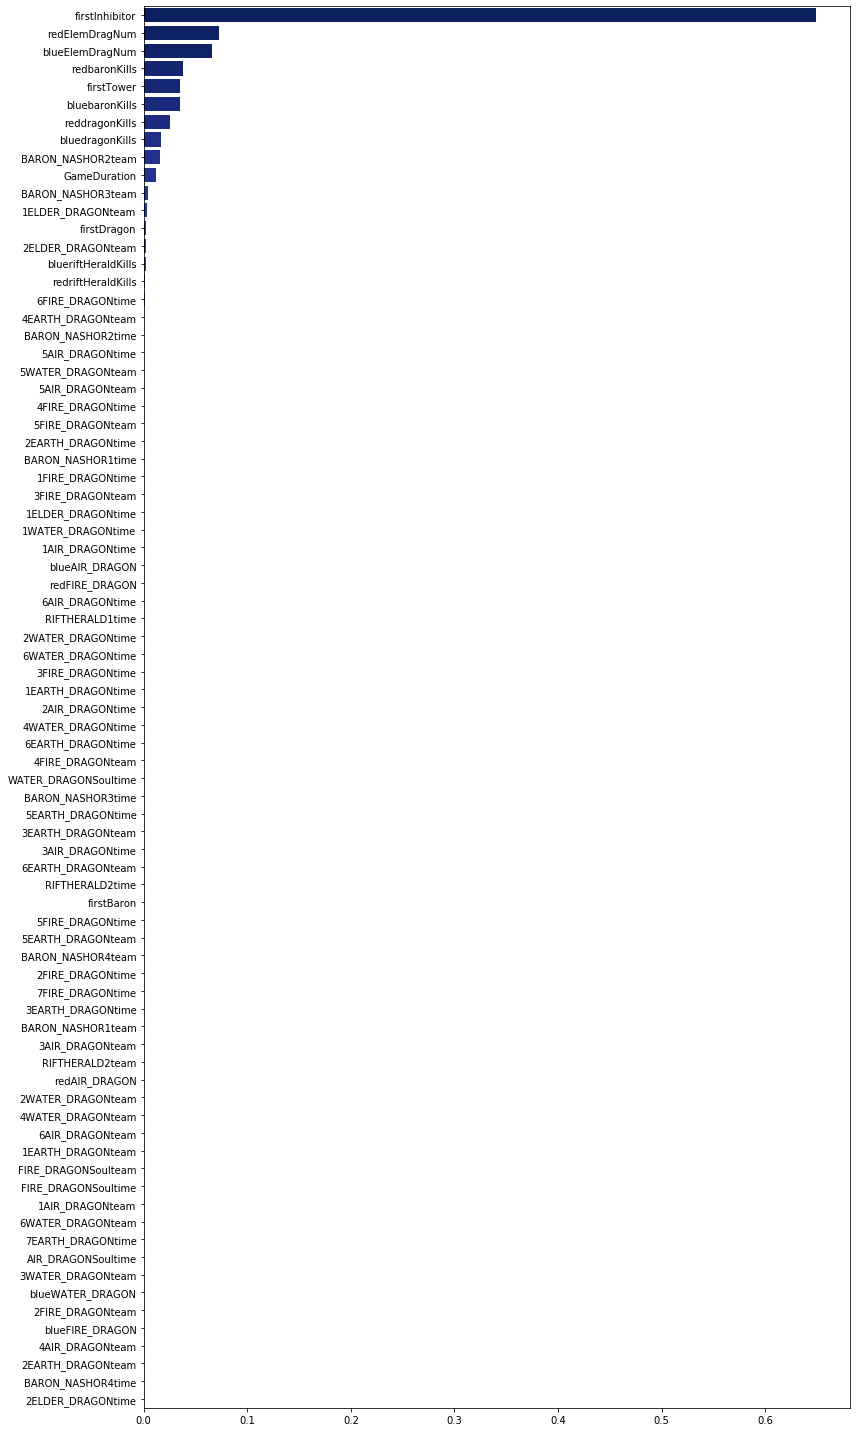

In [969]:
plot_barh(feat_importances[feat_importances > 0].sort_values())

In [971]:
pd.DataFrame(feat_importances[feat_importances > 0])

,0
firstInhibitor,6.489103e-01
redElemDragNum,7.295672e-02
blueElemDragNum,6.624017e-02
redbaronKills,3.830563e-02
firstTower,3.491930e-02
...,...
blueFIRE_DRAGON,1.690759e-05
4AIR_DRAGONteam,2.279306e-06
2EARTH_DRAGONteam,1.420384e-06
BARON_NASHOR4time,1.109049e-06


In [930]:
feat_importances[var_soul].sort_values(ascending=False)

WATER_DRAGONSoultime    0.000300
FIRE_DRAGONSoulteam     0.000099
FIRE_DRAGONSoultime     0.000098
AIR_DRAGONSoultime      0.000041
EARTH_DRAGONSoultime    0.000000
EARTH_DRAGONSoulteam    0.000000
AIR_DRAGONSoulteam      0.000000
WATER_DRAGONSoulteam    0.000000
dtype: float64

In [803]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.2, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [972]:
feat_importances[:30]

firstInhibitor         0.648910
redElemDragNum         0.072957
blueElemDragNum        0.066240
redbaronKills          0.038306
firstTower             0.034919
bluebaronKills         0.034776
reddragonKills         0.025468
bluedragonKills        0.016608
BARON_NASHOR2team      0.015860
GameDuration           0.012358
BARON_NASHOR3team      0.004313
1ELDER_DRAGONteam      0.003248
firstDragon            0.002674
2ELDER_DRAGONteam      0.002267
blueriftHeraldKills    0.001990
redriftHeraldKills     0.001301
6FIRE_DRAGONtime       0.000944
4EARTH_DRAGONteam      0.000799
BARON_NASHOR2time      0.000766
5AIR_DRAGONtime        0.000759
5WATER_DRAGONteam      0.000759
5AIR_DRAGONteam        0.000632
4FIRE_DRAGONtime       0.000627
5FIRE_DRAGONteam       0.000594
2EARTH_DRAGONtime      0.000560
BARON_NASHOR1time      0.000545
1FIRE_DRAGONtime       0.000491
3FIRE_DRAGONteam       0.000465
1ELDER_DRAGONtime      0.000429
1WATER_DRAGONtime      0.000426
dtype: float64

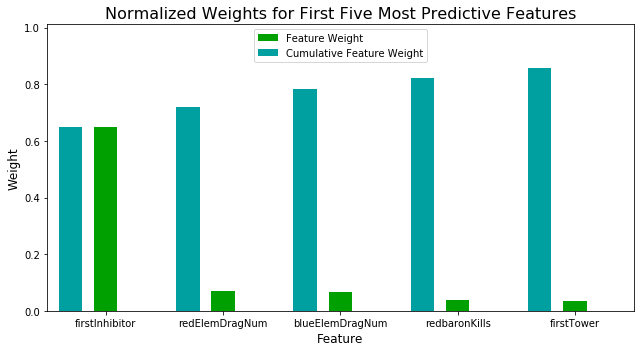

In [931]:
feature_plot(clf_GB.feature_importances_, X_train, y_train)

### Results of initial model

#### Dragon Soul

The data does seem to reflect what people think of the relative power levels of dragon souls - ocean is the most powerful IF you get it early. Cloud soul also contributes towards wins if it's obtained earlier in the game. This makes sense since ocean and cloud drake both grant advantages early and mid-game, but these advantages decrease as the game goes on. Come late game, the players' stats will have scaled enough and the game's pace will change to even out these dragon soul advantages. 

Ocean soul grants extra health and mana regeneration out of combat, which will help one team stay healthy throughout midgames during skirmishes, extended seiges and teamfights. Since it boosts regeneration, ocean soul is only useful if at least some players on a team stay alive after combat. Turrets still do significant damage to players midgame, so even if not everyone on a is alive, ocean soul helps the alive players stay healthy to defend with the safety of  structures. As the game goes on, player damage will have also increased to the point that players are more likely to die and the death timers are longer. Additionally, structural defenses, turrets, do less meaningful damage to players while players can destroy them more easily. As deaths become more impactful, any player who remain alive on a team while some of their teammates are dead find that ocean soul becomes less helpful in defense. 

Cloud soul increases movement speed and cooldown reduction on spells, granting one team a tempo advantage in moving around the map and having increased access to useful ultimate spells. Player will have more CDR items and have decreased cooldowns with higher level spells, so players will be more likely to have equal access to their ultimate spells later in the game. 

Infernal soul, on the other hand, remains powerful regardless of when the team obtains it. The infernal soul grants percent-based permanent damage bonuses to a team, so that advantage remains throughout the course of a game.

The top 5 most predictive features are:
1. team that takes first inhibitor
2. number of elemental dragons taken by red team
3. number of elemental dragons taken by blue team
4. number of baron kills taken by the red team
5. team that takes first tower

Which team kills the first inhibitor seems to be the best predictor of who will win the game. This makes sense since killing an inhibitor is the most direct path towards killing the enemy nexus. The first inhibitor kill accounts for 60% of the weights for predicting the game winner. 

The total number of elemental drakes taken by a team is the next best predictor, with red team dragon kills being slightly more predictive than blue team's. Without doing further analysis it's hard to say whether this difference is statistically significant. We can speculate that perhaps the red team's larger relative distance from the dragon pit compared to the blue team means that red team naturally has less control over the dragon; therefore, if the red team is successful at capturing dragon objectives, red likely has a strong control over the game carrying over to wins.

The order of importance of neutral objectives to the game result seems to be:
#### elemental dragons > baron > elder dragon > rift herald

### Early objectives

Of all the early objectives available (inhibitor, tower, dragon, baron, rift herald), it seems that the non-neutral objectives, inhibitors and towers, are the most predictive, followed by dragon and baron. First rift herald seem to have no predictive weight on the winner at all.

Of course, the associations here must be taken with a grain of salt before tranlating them to causation. Having early game pressure will translate to more objective control. However, it is very telling that first dragon has more weight than first herald, when both of these objectives are usually captured around the same time and are often "traded" for each other (if one team takes one, the other team will take the other).

In [ ]:
bool_params = ['firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 
               'firstRiftHerald']
num_params = ['baronKills', 'riftHeraldKills', 'dragonKills']

In [979]:
feat_importances[bool_params].sort_values(ascending=False)

firstInhibitor     0.648910
firstTower         0.034919
firstDragon        0.002674
firstBaron         0.000188
firstRiftHerald    0.000000
dtype: float64

<BarContainer object of 5 artists>

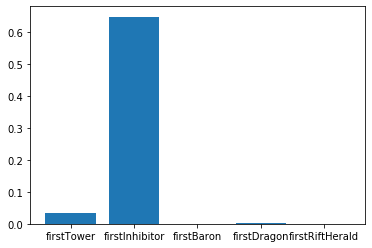

In [977]:
plt.bar(feat_importances[bool_params].index, feat_importances[bool_params])